Restarted base (Python 3.12.2)

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel
from transformers.models.llama import LlamaModel
from transformers.models.gpt2 import GPT2Model
from enum import Enum
from types import SimpleNamespace
from typing import Union
from collections import defaultdict

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
deep_dive_heads = False

In [ ]:
class DatasetTypes(Enum):
    WIKI = ("wikitext", "wikitext-2-raw-v1")
    INTERNET = ("allenai/c4", "en")
    CODE = "bigcode/starcoderdata"
    ASSISTANT = "HuggingFaceH4/ultrachat_200k"


class ModelTypes(Enum):
    GPT2 = "gpt2"
    LLAMA = "meta-llama/Meta-Llama-3.1-8B"
    GEMMA = "google/gemma-2-9b-it"
    TINY_LLAMA = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"


def get_dataset(dataset_type: DatasetTypes):
    if dataset_type == DatasetTypes.WIKI or dataset_type == DatasetTypes.INTERNET:
        return load_dataset(
            dataset_type.value[0], dataset_type.value[1], streaming=True
        )
    return load_dataset(dataset_type.value, streaming=True)


def get_tokenizer_model(model_type: ModelTypes):
    model_name = model_type.value
    return AutoTokenizer.from_pretrained(
        model_name
    ), AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)


def get_model_config(
    model_type: ModelTypes, model: Union[LlamaModel, GPT2Model, PreTrainedModel]
) -> SimpleNamespace:
    if model_type == ModelTypes.GPT2:
        return SimpleNamespace(n_layer=model.config.n_layer, n_head=model.config.n_head)
    return SimpleNamespace(
        n_layer=model.config.num_hidden_layers,
        n_head=model.config.num_attention_heads,
        seq_len=model.config.max_position_embeddings,
    )

In [ ]:
dataset = get_dataset(DatasetTypes.INTERNET)

In [ ]:
model_type = ModelTypes.TINY_LLAMA
tokenizer, model = get_tokenizer_model(model_type)
config = get_model_config(model_type, model)
config

namespace(n_layer=22, n_head=32, seq_len=2048)

In [ ]:
num_of_samples = 100

In [ ]:
stream = iter(dataset["train"])

In [ ]:
seq_len = config.seq_len
head_metrics = {
    "cum_prob": {
        "best": torch.zeros((config.n_layer, config.n_head, seq_len)),
        "avg": torch.zeros((config.n_layer, config.n_head, seq_len)),
        "worst": torch.ones((config.n_layer, config.n_head, seq_len)),
    },
    "att_wei": {
        "best": torch.zeros((config.n_layer, config.n_head, seq_len)),
        "avg": torch.zeros((config.n_layer, config.n_head, seq_len)),
        "worst": torch.ones((config.n_layer, config.n_head, seq_len)),
    },
}
layer_cumsum_metrics = {
    "best": torch.zeros((config.n_layer, config.n_head * seq_len)),
    "avg": torch.zeros((config.n_layer, config.n_head * seq_len)),
    "worst": torch.full((config.n_layer, config.n_head * seq_len), torch.inf),
}

In [ ]:
for i in range(num_of_samples):
    cur_seq_len = 0

    while cur_seq_len <= seq_len:
        input_text = next(stream)["text"]
        inputs = tokenizer(input_text, return_tensors="pt")
        cur_seq_len = inputs.input_ids.shape[1]

    # cap length of input to min sequence length tokens
    inputs_sliced = {
        "input_ids": inputs.input_ids[:, :seq_len],
        "attention_mask": inputs.attention_mask[:, :seq_len],
    }

    metrics = defaultdict(
        lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0)))
    )

    # Run the model
    with torch.no_grad():
        outputs = model(**inputs_sliced)

    attentions = torch.cat(outputs.attentions, dim=0)
    att_wei = attentions[:, :, -1, :]  # get query projection

    head_metrics["att_wei"]["avg"] += att_wei
    head_metrics["att_wei"]["best"] = torch.max(
        att_wei, head_metrics["att_wei"]["best"]
    )
    head_metrics["att_wei"]["worst"] = torch.min(
        att_wei, head_metrics["att_wei"]["worst"]
    )

    layer_att_wei = torch.reshape(att_wei, (config.n_layer, config.n_head * seq_len))

    att_wei = torch.sort(att_wei, dim=-1, descending=True).values
    layer_att_wei = torch.sort(layer_att_wei, dim=-1, descending=True).values

    cum_prob = att_wei.cumsum(dim=-1)
    cum_layer_prob = layer_att_wei.cumsum(dim=-1)

    head_metrics["cum_prob"]["avg"] += cum_prob
    head_metrics["cum_prob"]["best"] = torch.max(
        head_metrics["cum_prob"]["best"], cum_prob
    )
    head_metrics["cum_prob"]["worst"] = torch.min(
        head_metrics["cum_prob"]["worst"], cum_prob
    )

    layer_cumsum_metrics["avg"] += cum_layer_prob
    layer_cumsum_metrics["best"] = torch.max(
        layer_cumsum_metrics["best"], cum_layer_prob
    )
    layer_cumsum_metrics["worst"] = torch.min(
        layer_cumsum_metrics["worst"], cum_layer_prob
    )

Token indices sequence length is longer than the specified maximum sequence length for this model (2853 > 2048). Running this sequence through the model will result in indexing errors
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [ ]:
head_metrics["att_wei"]["avg"] = head_metrics["att_wei"]["avg"] / num_of_samples
head_metrics["cum_prob"]["avg"] = head_metrics["cum_prob"]["avg"] / num_of_samples
layer_cumsum_metrics["avg"] = (
    layer_cumsum_metrics["avg"] / num_of_samples / config.n_head
)

layer_cumsum_metrics["best"] = layer_cumsum_metrics["best"] / config.n_head
layer_cumsum_metrics["worst"] = layer_cumsum_metrics["worst"] / config.n_head

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# %%

def plot_cum_layer_prob(layer_metrics):
    n_layers, k_len = layer_metrics.shape

    # Create a color map for the
    colors = plt.cm.rainbow(np.linspace(0, 1, n_layers))

    plt.figure(figsize=(15, 8))
    for layer in range(n_layers):
        # Create a new figure for each layer

        # Plot the line for thislayer
        plt.plot(
            range(k_len),
            layer_metrics[layer, :],
            color=colors[layer],
            label=f"Layer {layer}",
        )

    plt.title(f"Cumulative probability for all layers", fontsize=16)
    plt.xlabel("Number of keys", fontsize=12)
    plt.ylabel("Cumulative probability", fontsize=12)
    plt.ylim(0, 1)  # Assuming cumulative values are between 0 and 1
    plt.minorticks_on()

    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    # Add a legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

    plt.tight_layout()
    plt.show()

best cum prob across layers


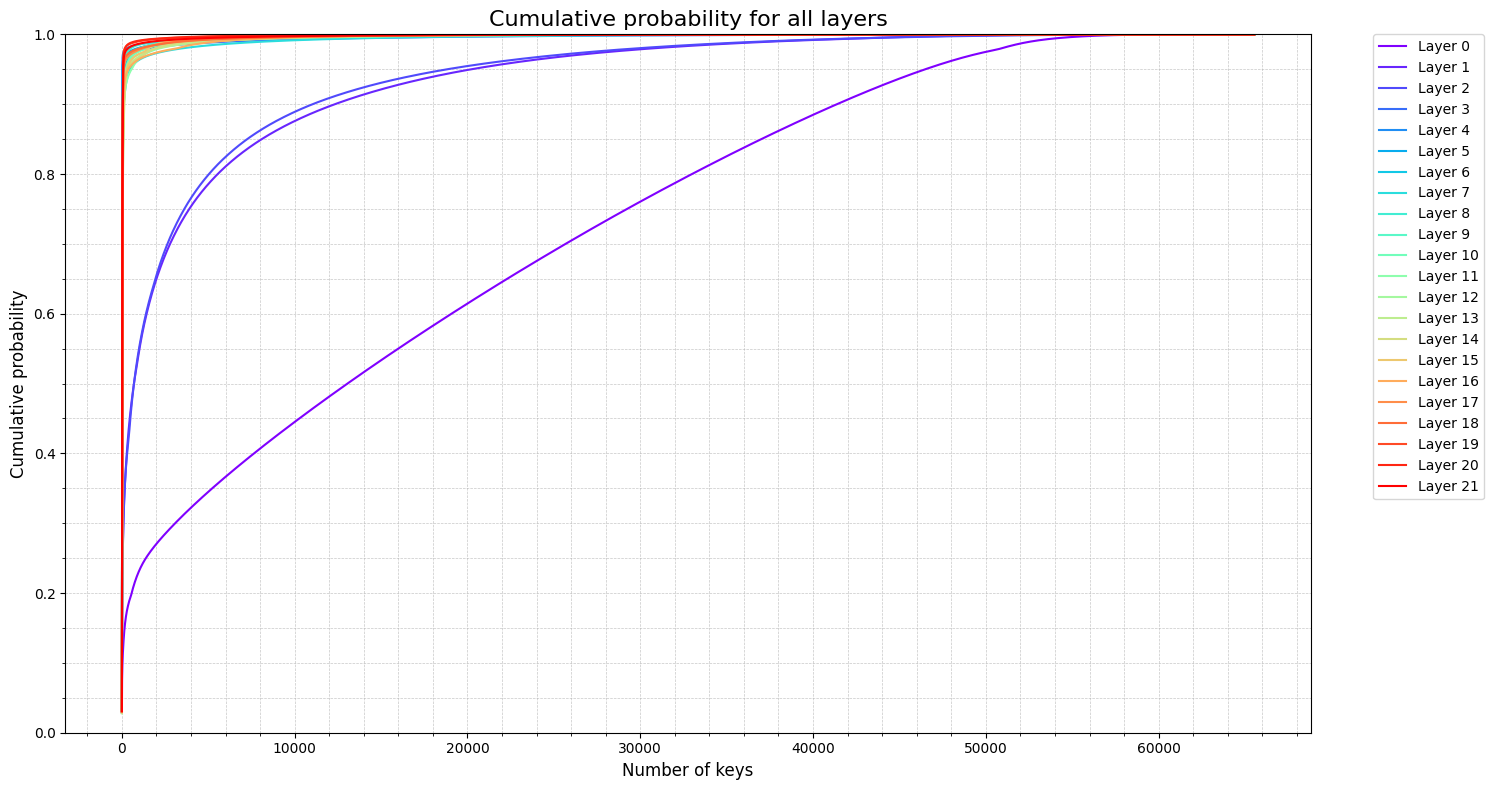

avg cum prob across layers


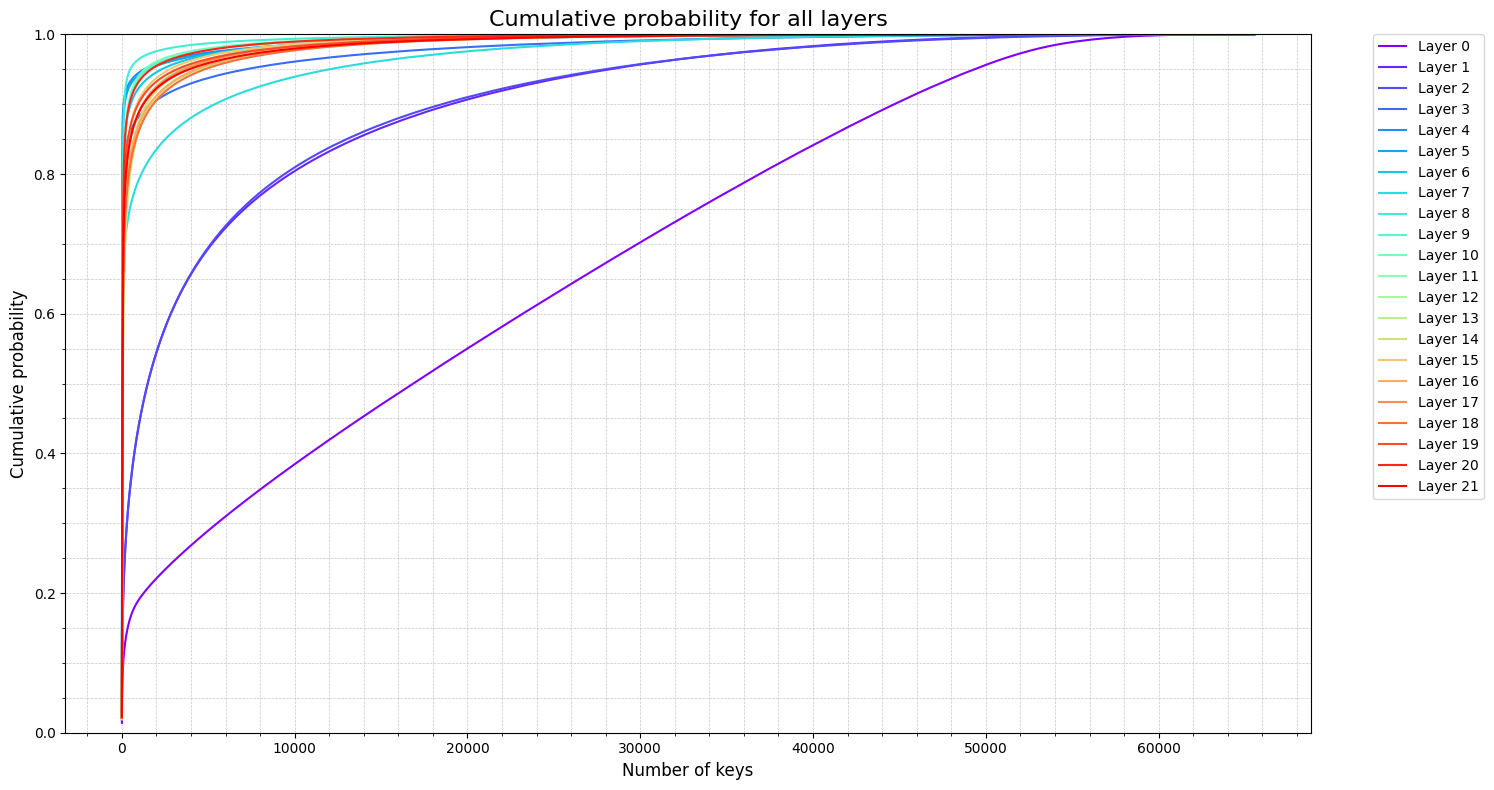

worst cum prob across layers


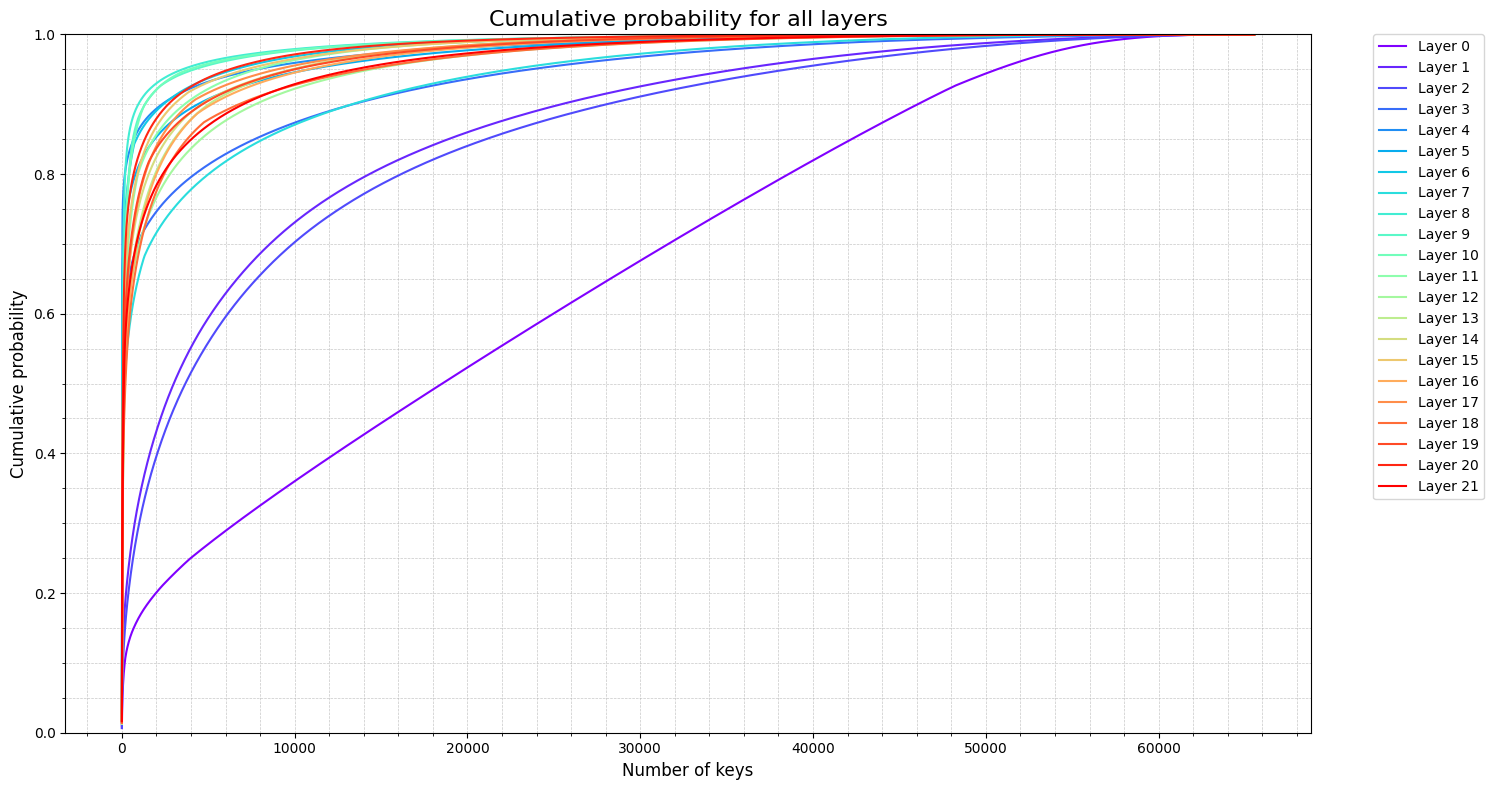

In [ ]:
# %%

for k in layer_cumsum_metrics.keys():
    print(f"{k} cum prob across layers")
    plot_cum_layer_prob(layer_cumsum_metrics[k].numpy())

In [ ]:
# %%

def plot_cum_prob_per_head(head_metrics):
    num_layers, num_heads, seq_length = head_metrics.shape

    # Create a color map for the heads
    colors = plt.cm.rainbow(np.linspace(0, 1, num_heads))

    for layer in range(num_layers):
        # Create a new figure for each layer
        plt.figure(figsize=(15, 8))

        for head in range(num_heads):
            # Get data for the current head
            head_data = head_metrics[layer, head, :]

            # Plot the line for this head
            plt.plot(
                range(seq_length), head_data, color=colors[head], label=f"Head {head}"
            )

        plt.title(f"Cumulative probability for Layer {layer}", fontsize=16)
        plt.xlabel("Number of keys", fontsize=12)
        plt.ylabel("Cumulative probability", fontsize=12)
        plt.ylim(0, 1)  # Assuming cumulative values are between 0 and 1

        # Add a legend
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

        plt.tight_layout()
        plt.show()

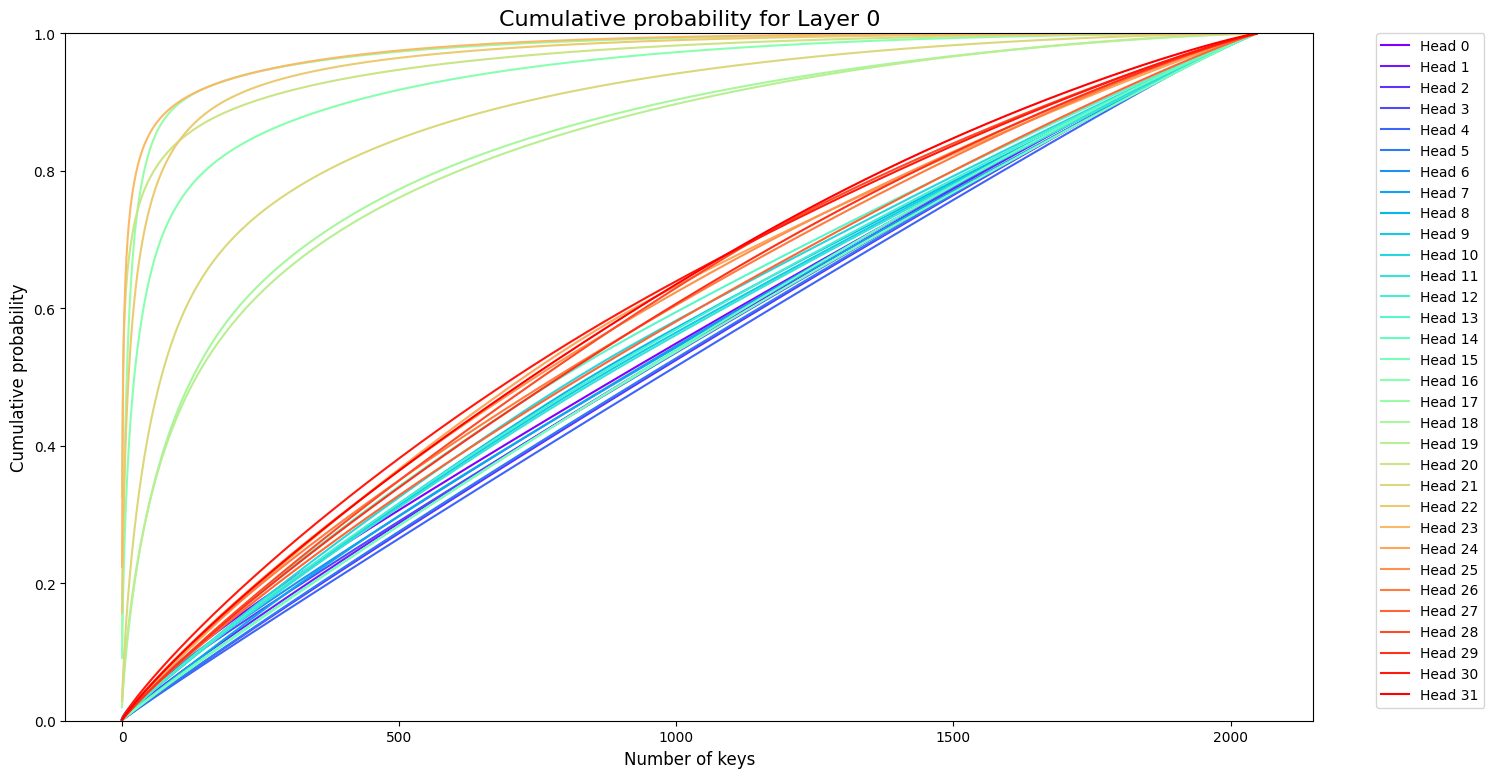

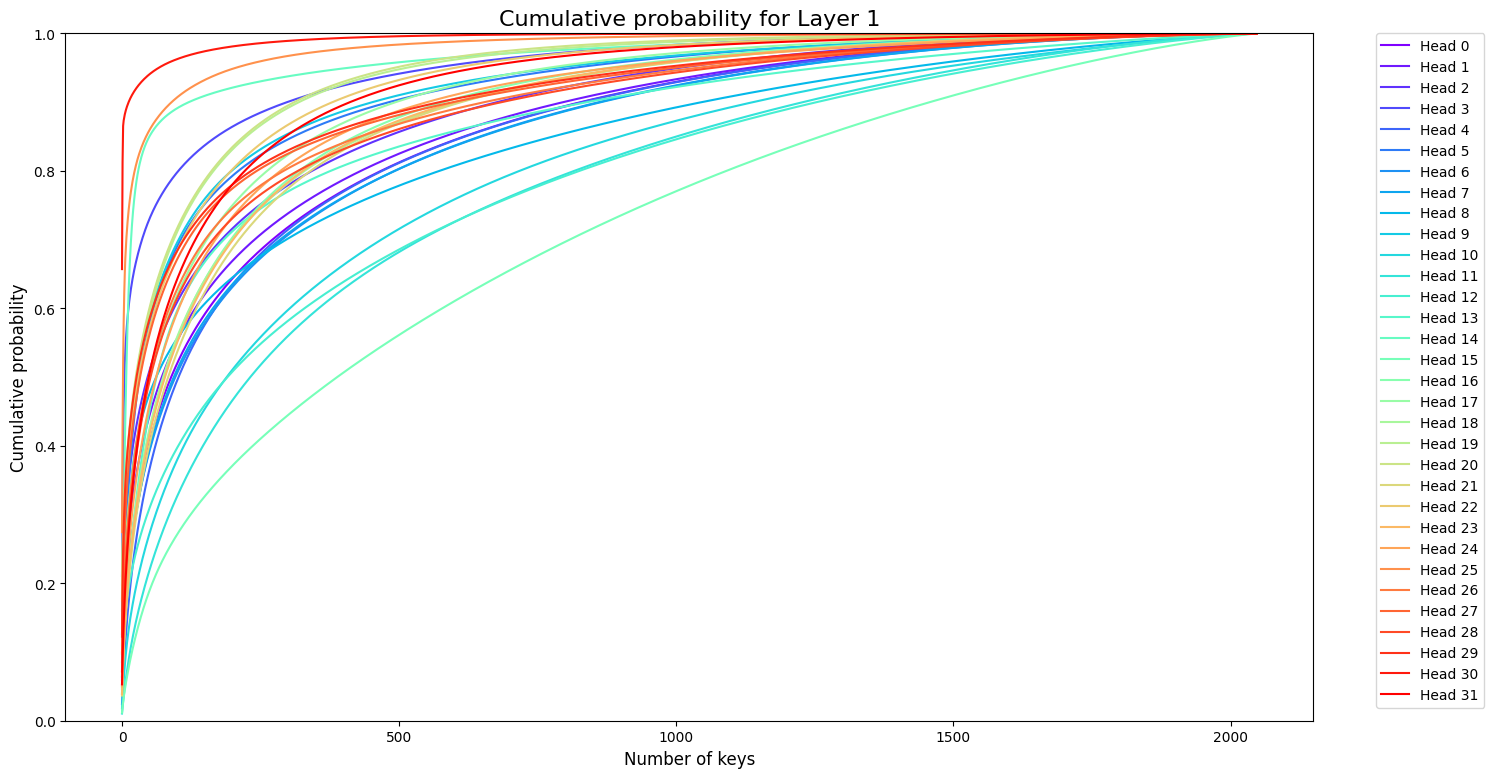

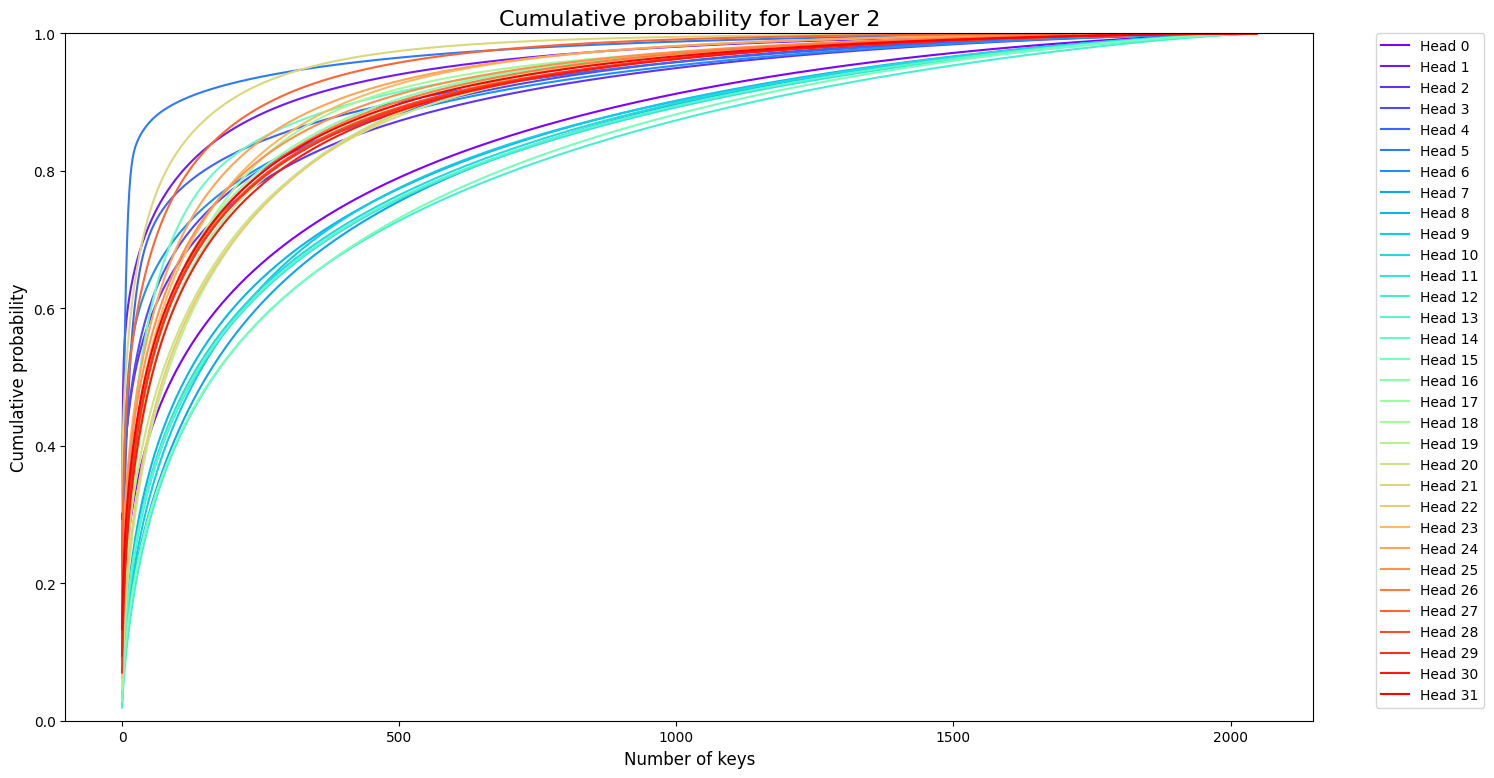

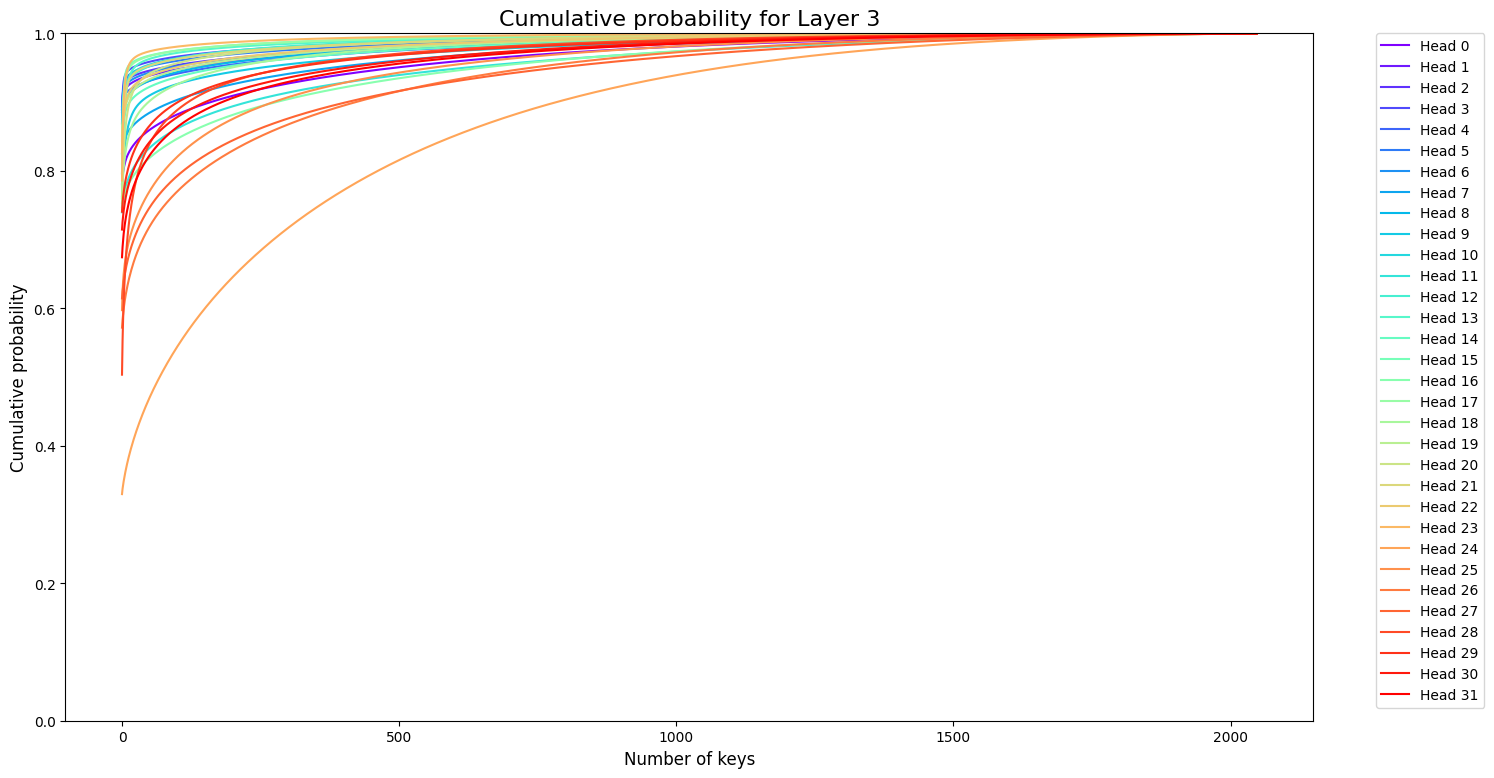

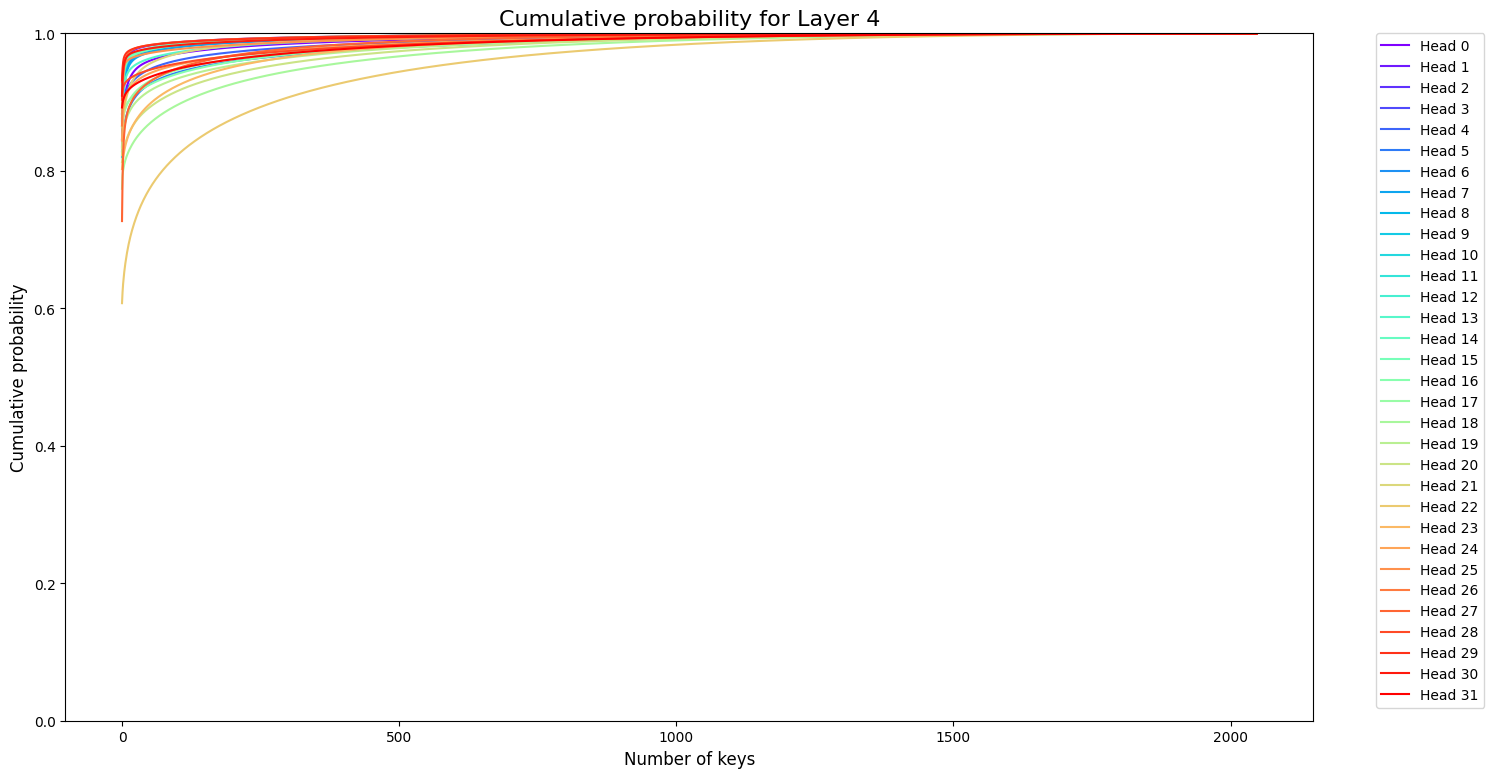

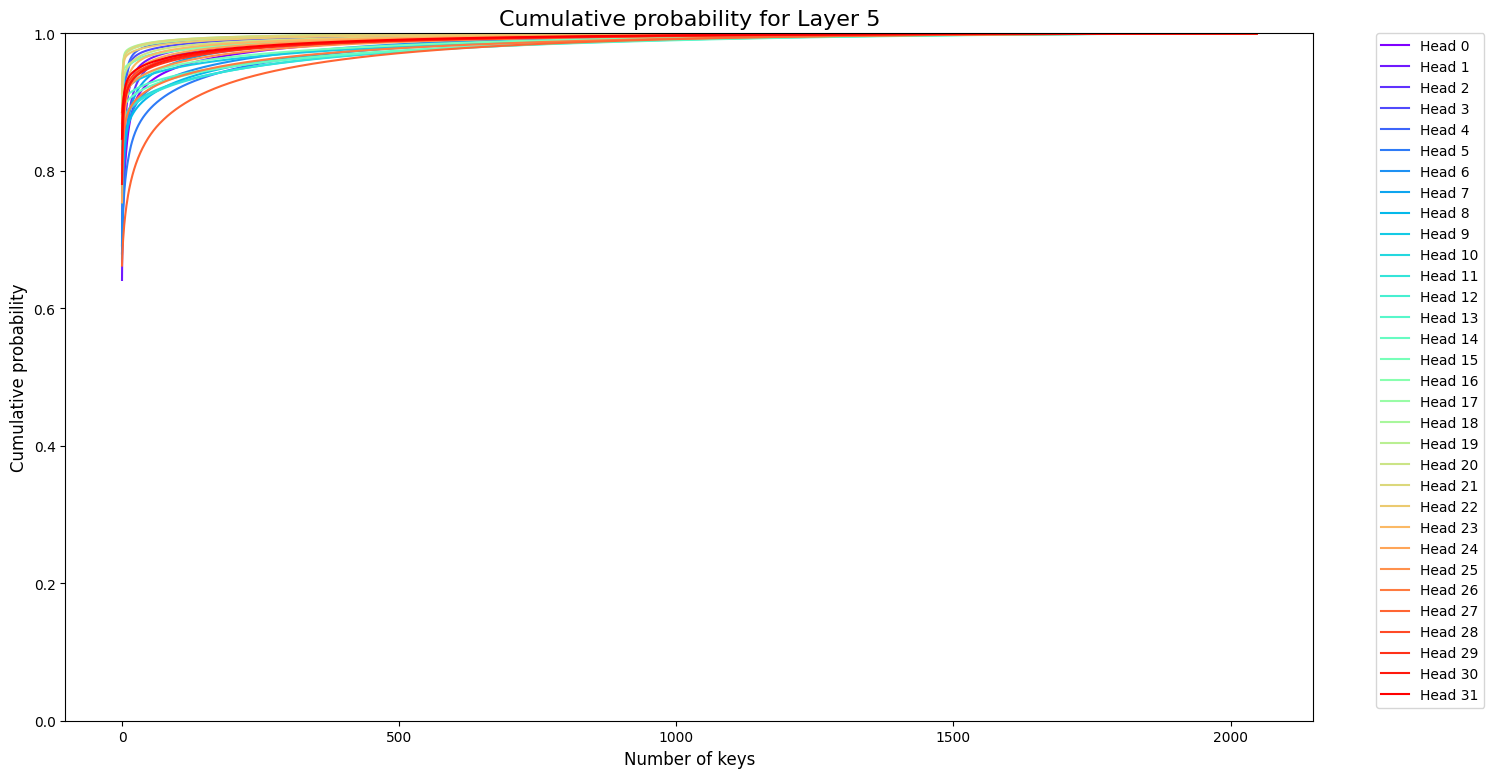

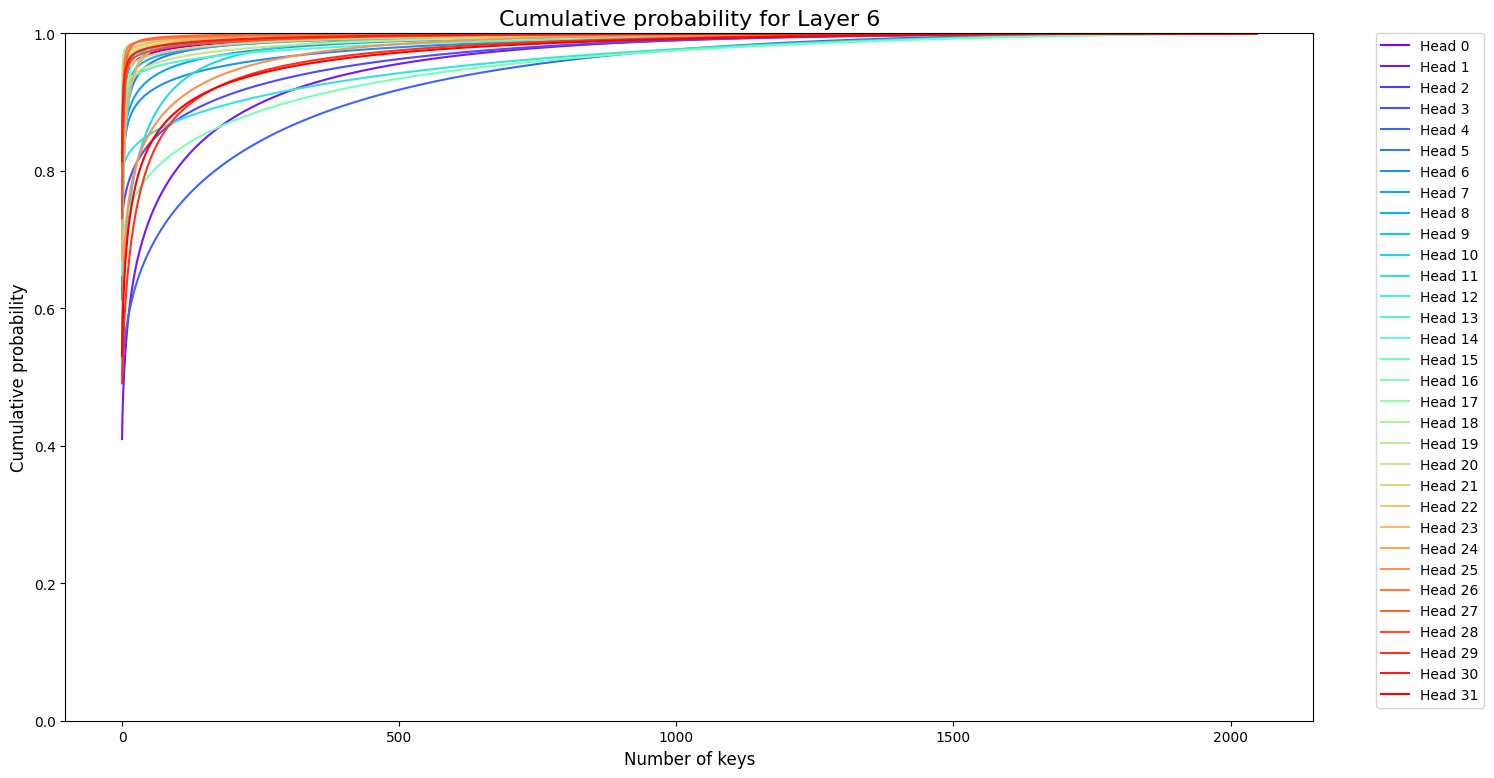

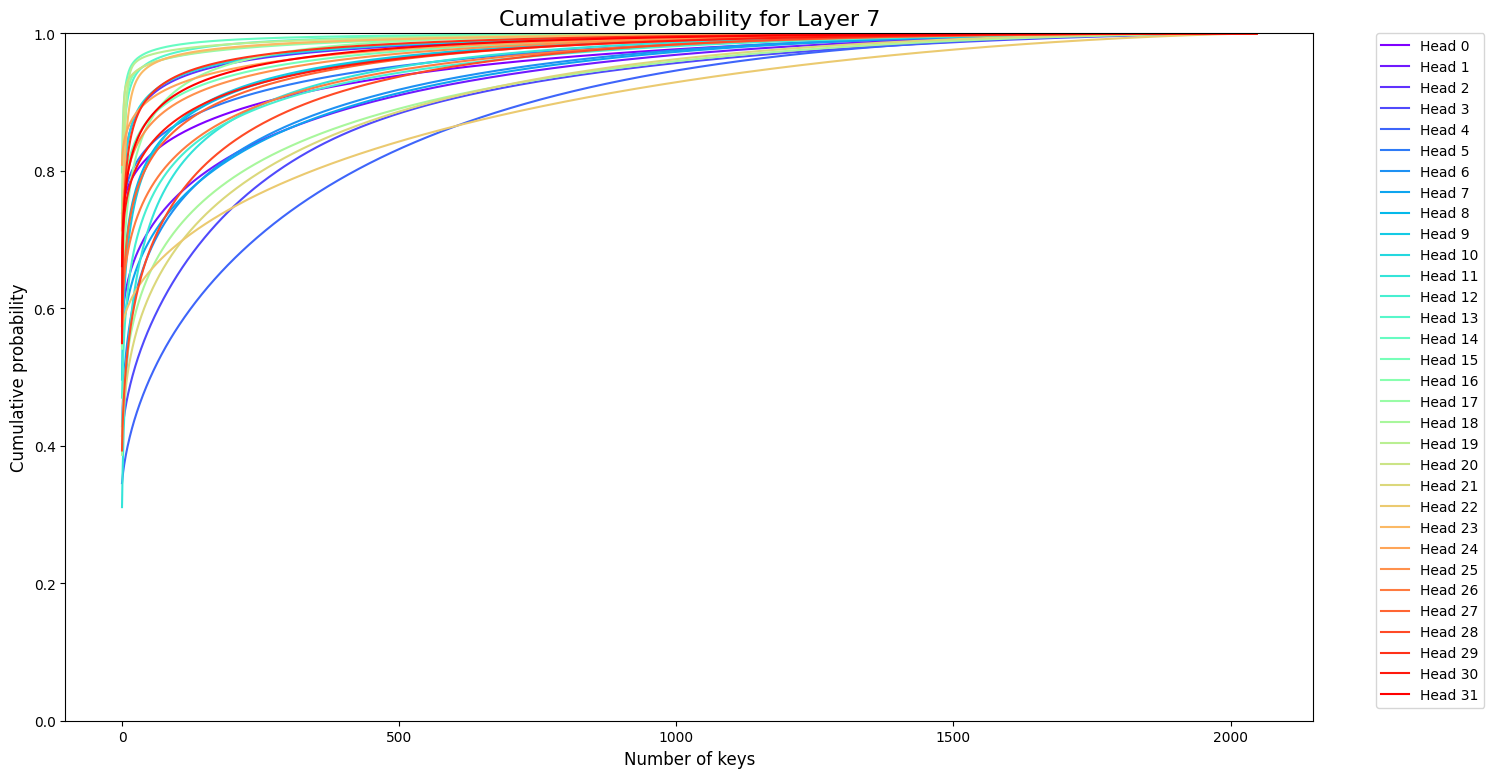

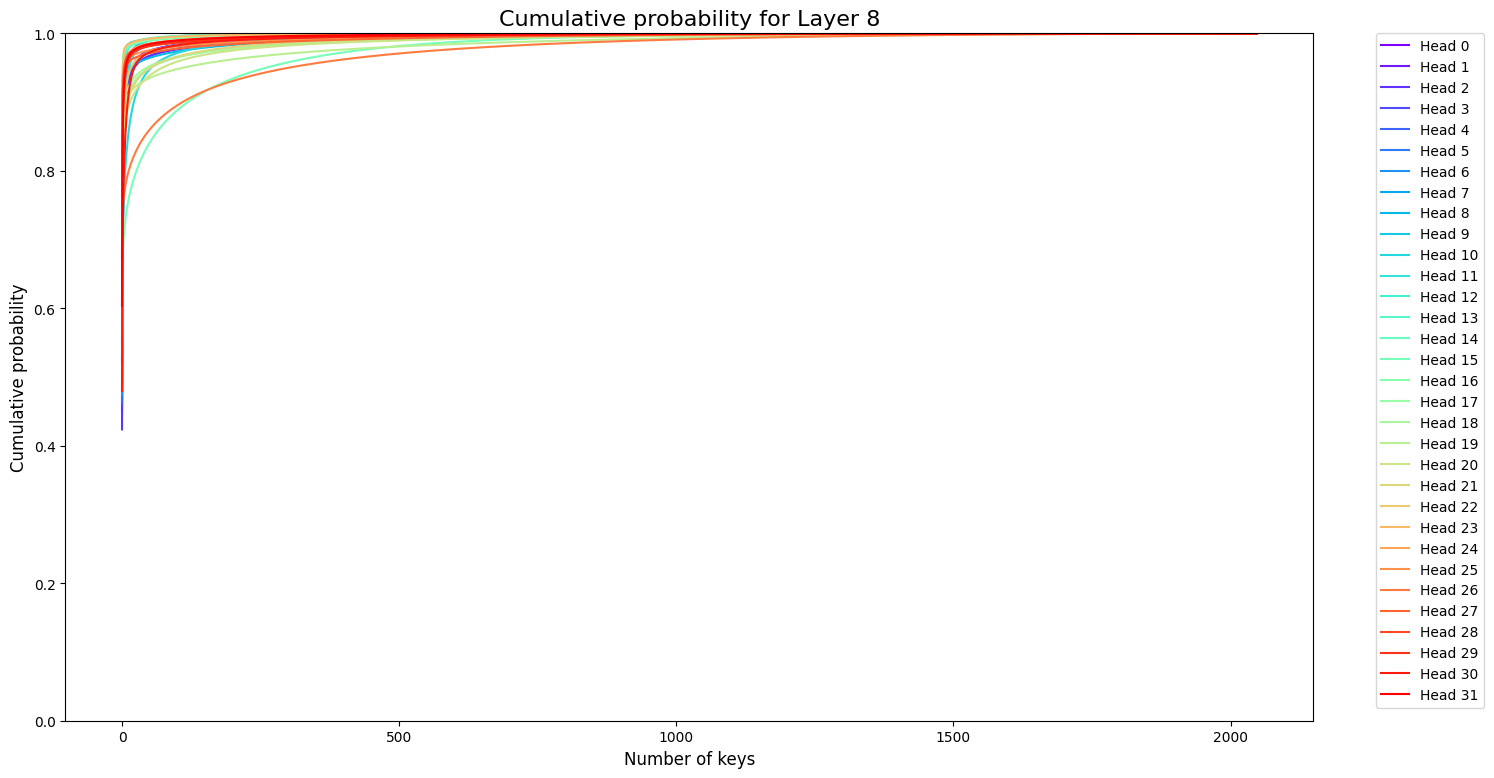

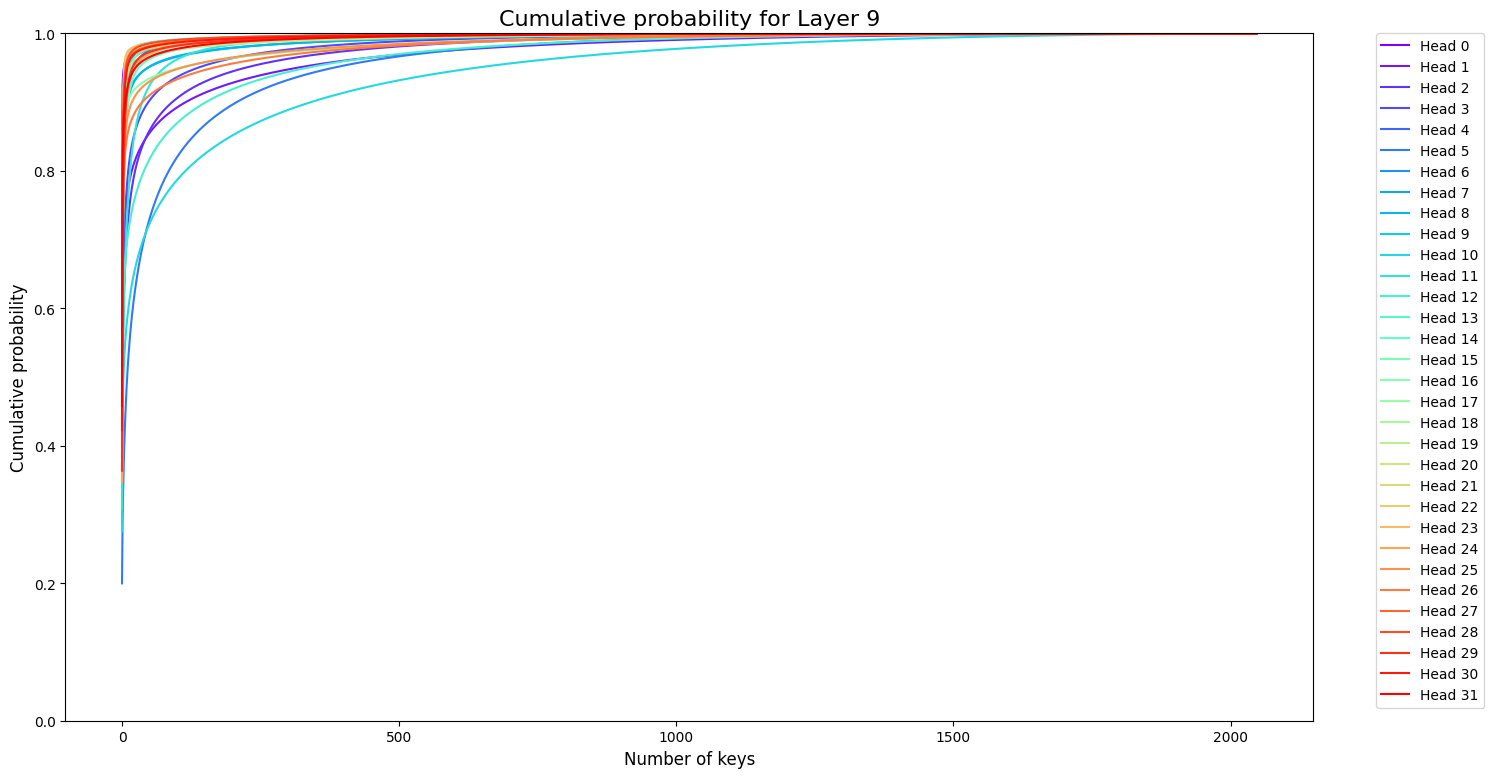

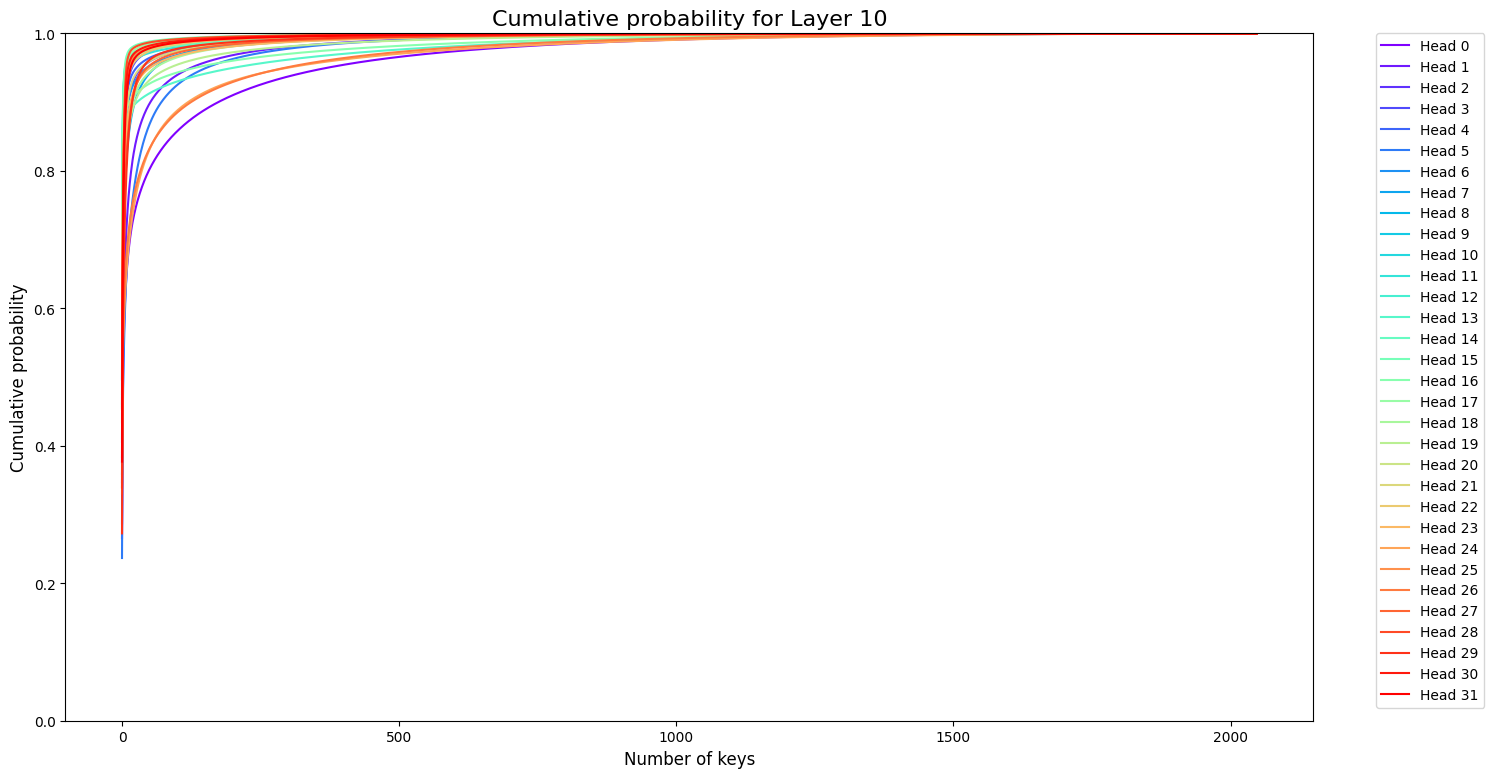

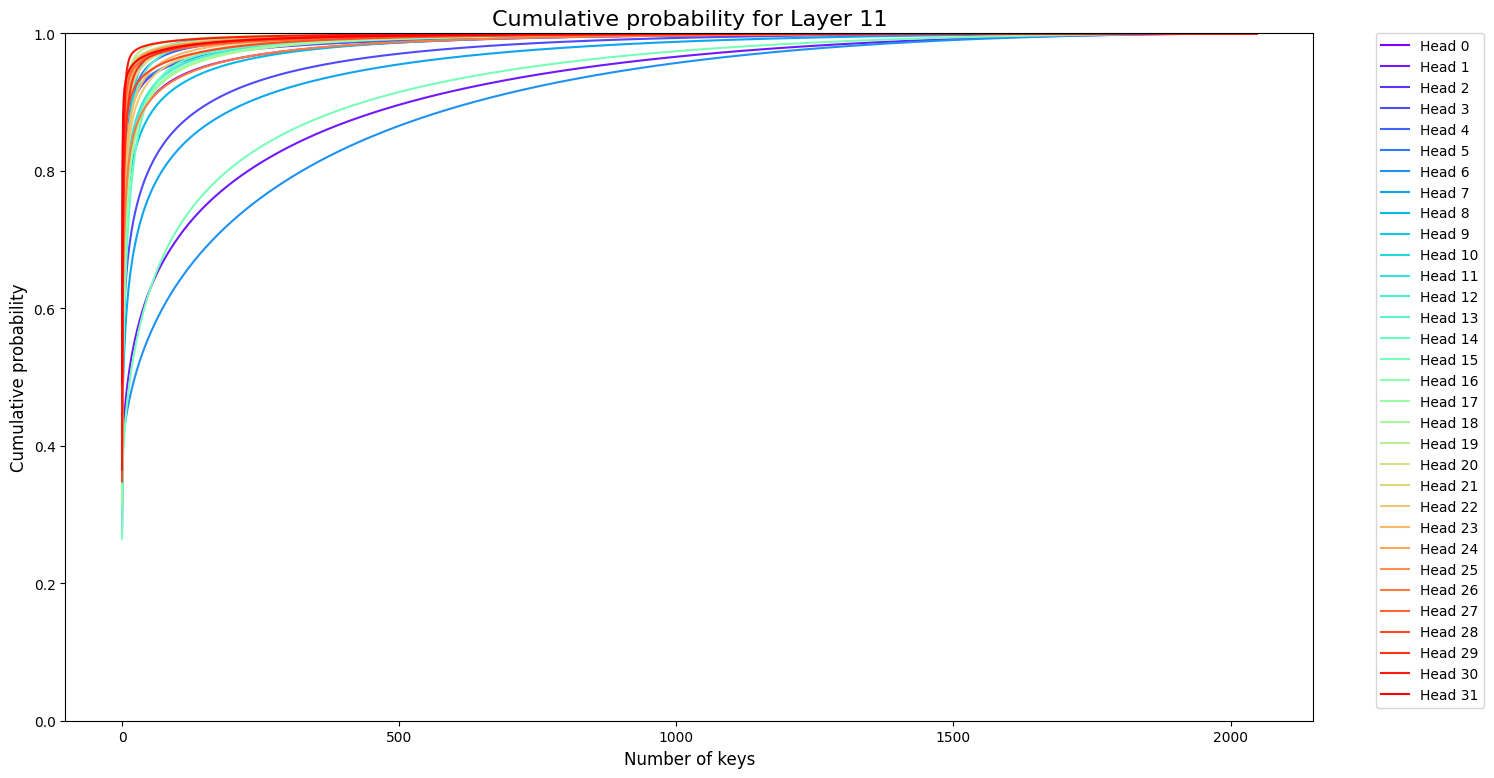

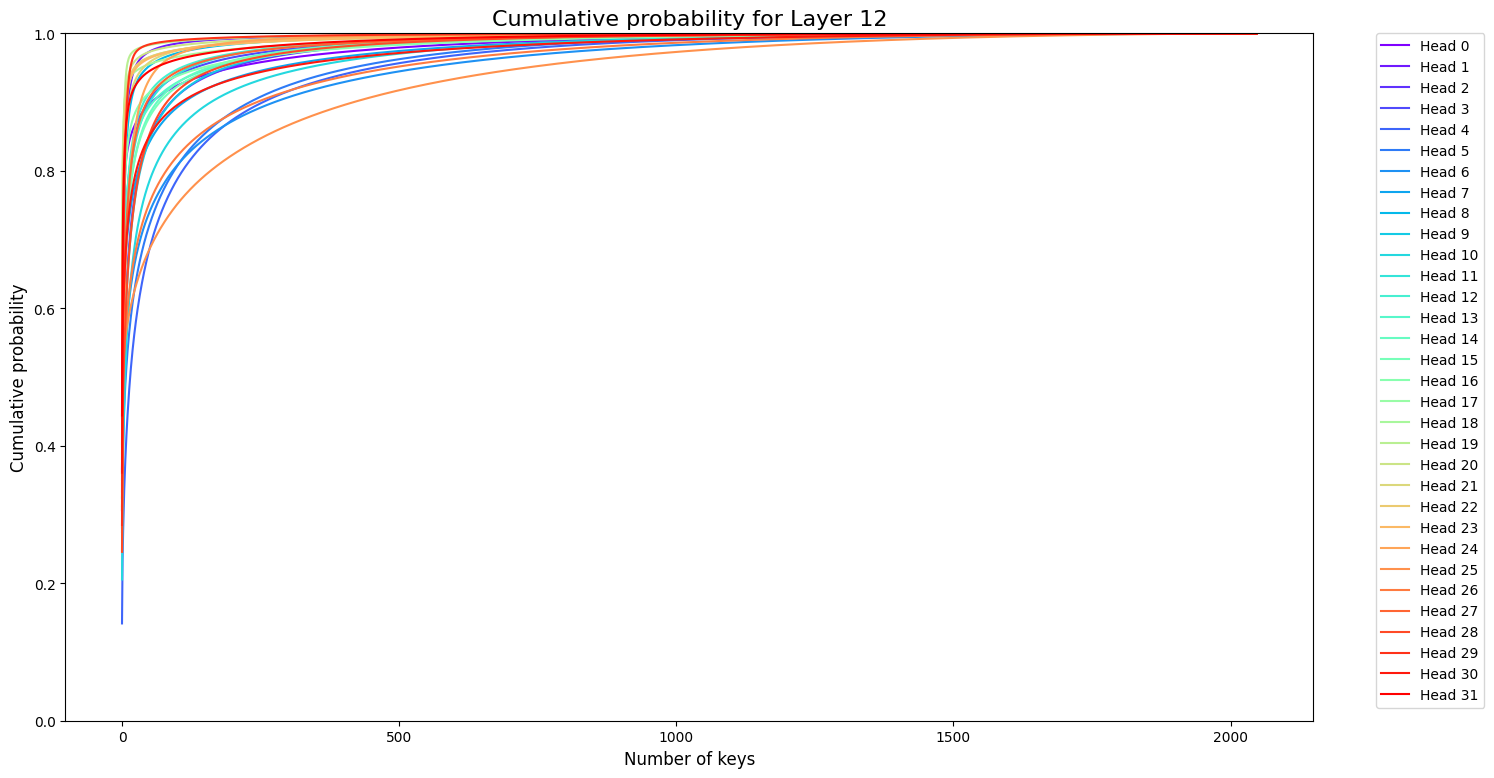

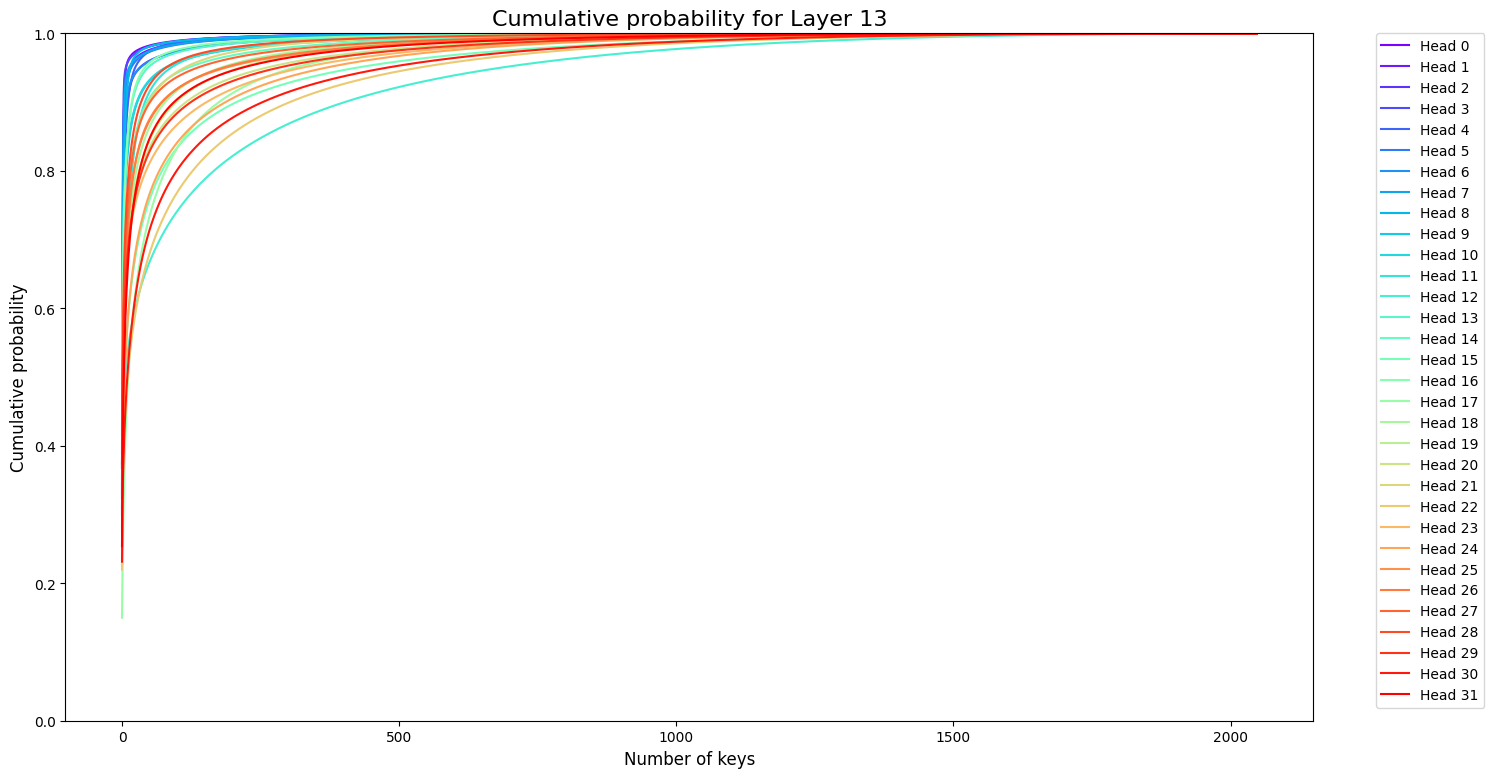

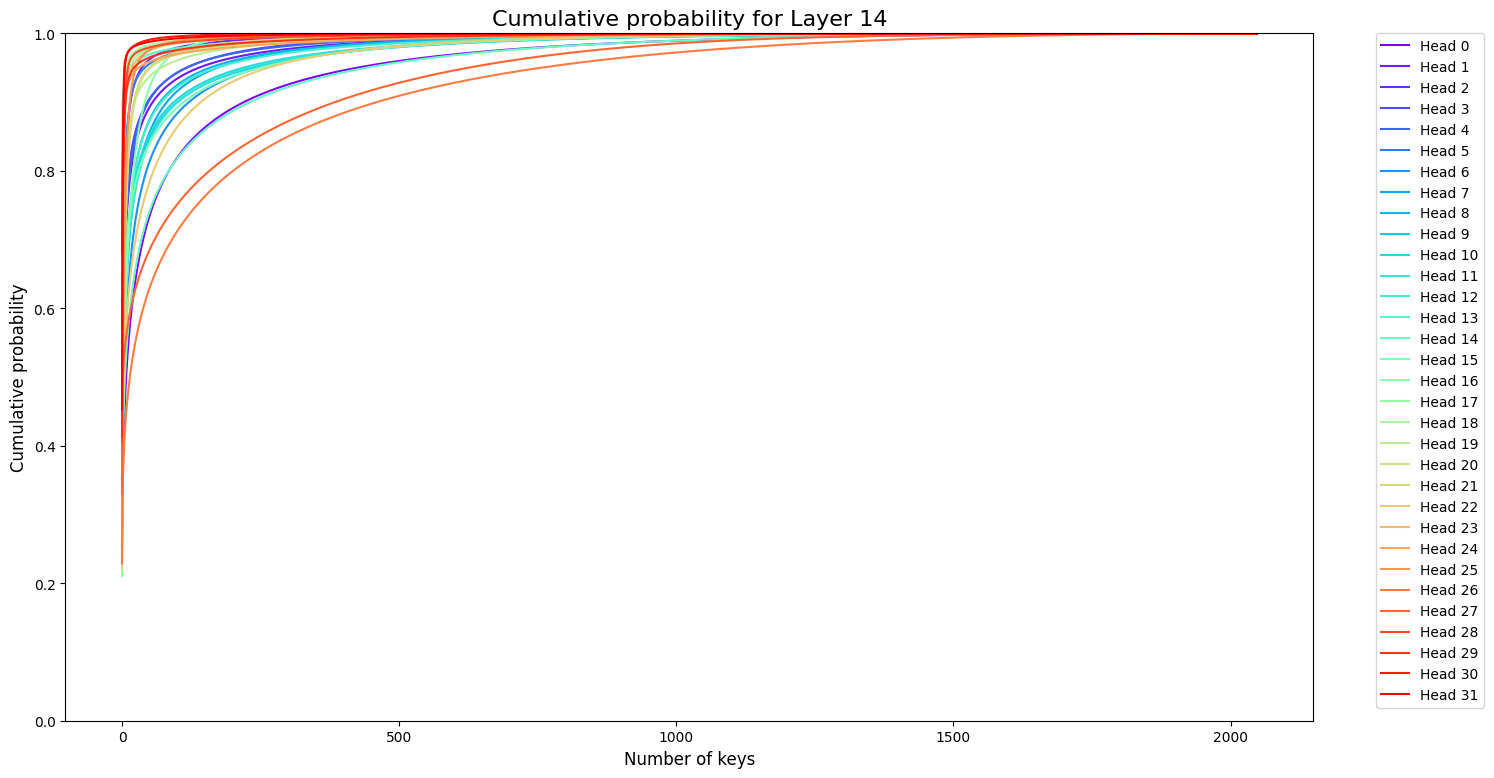

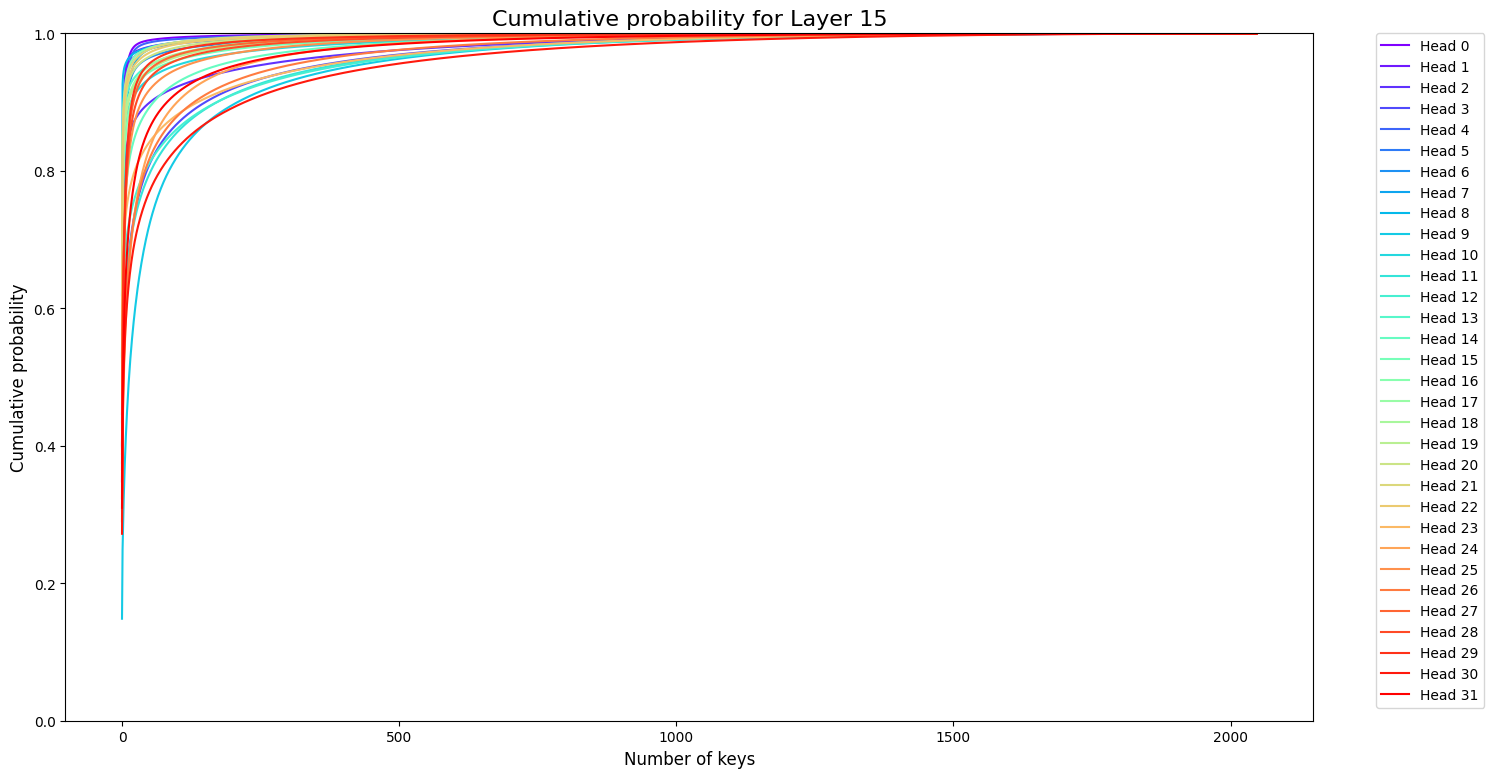

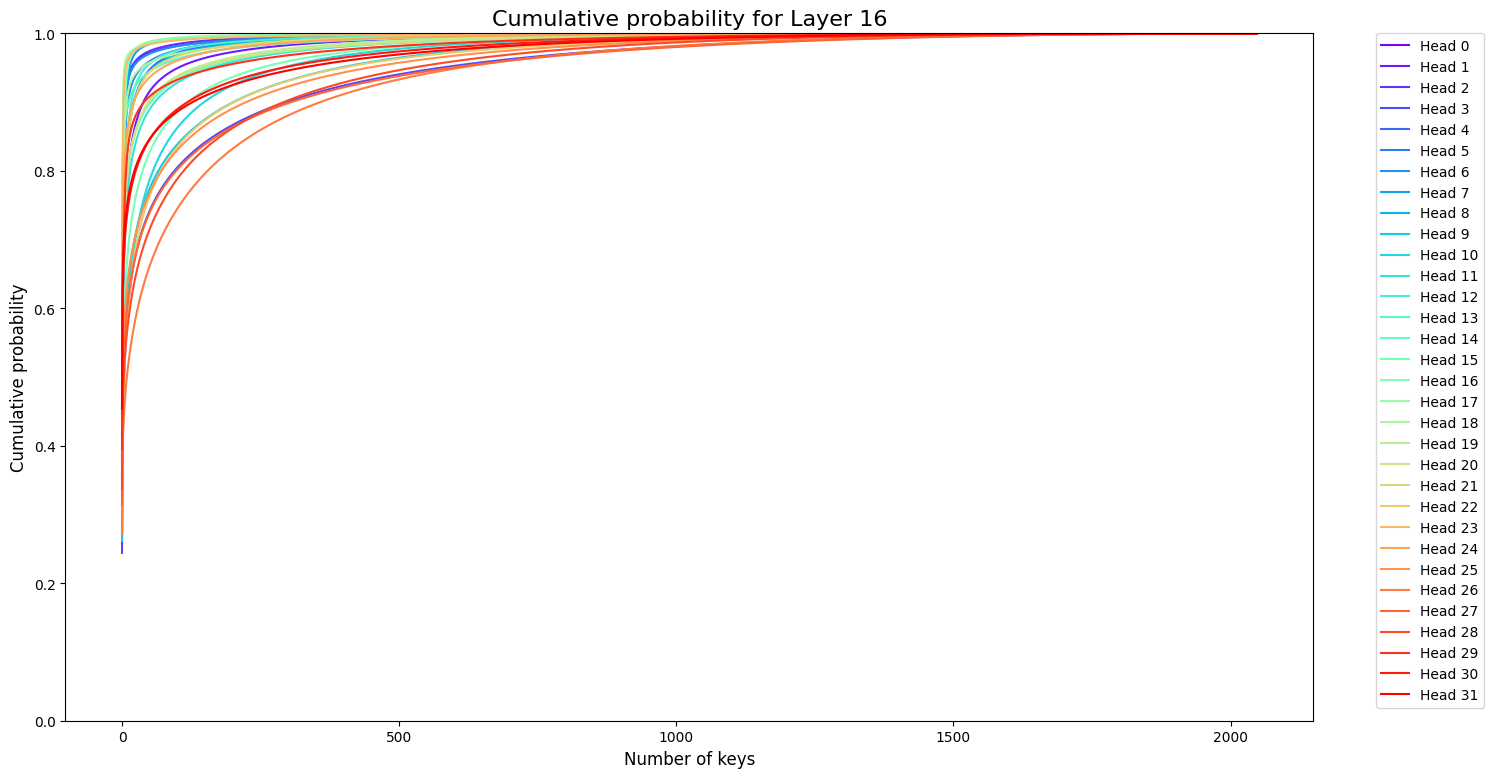

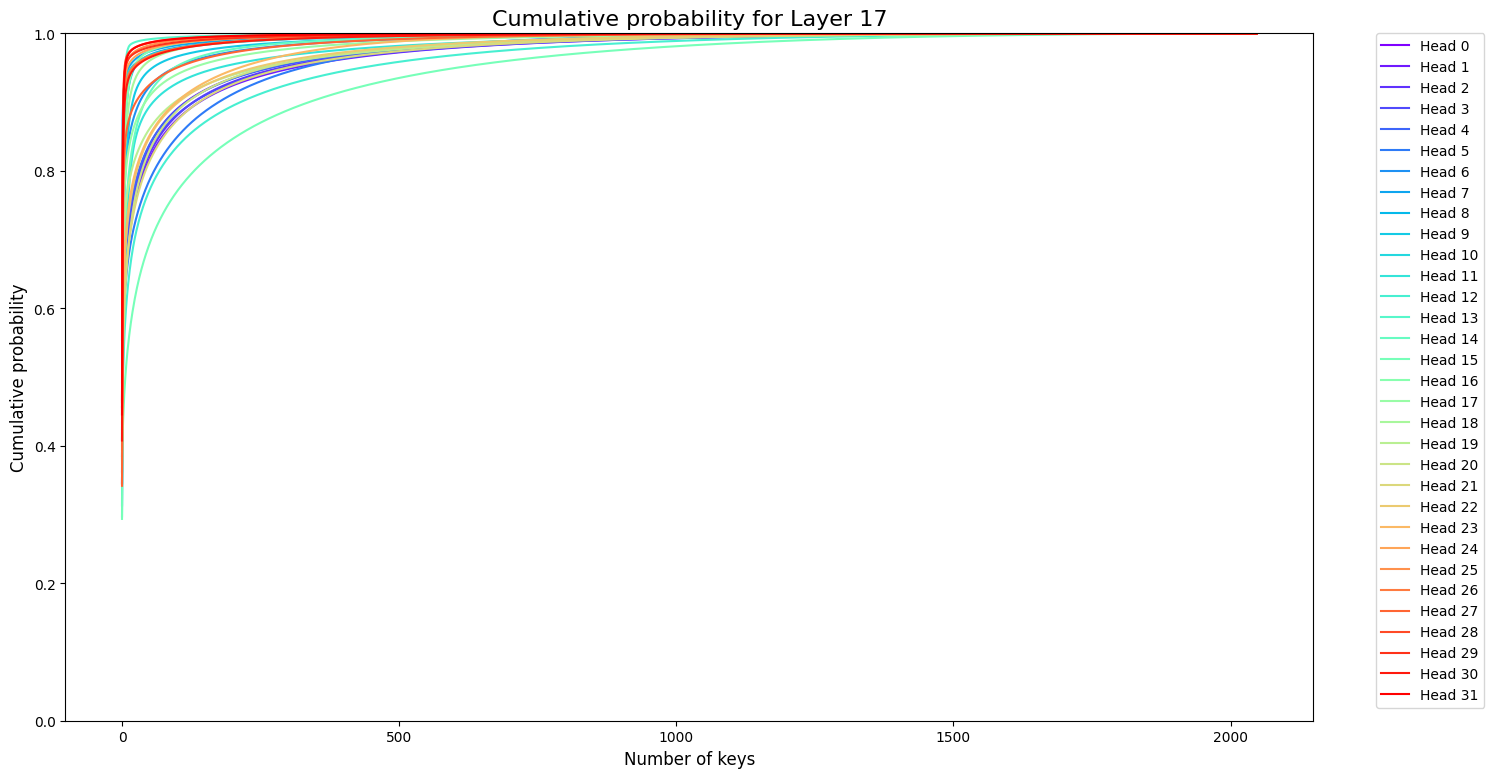

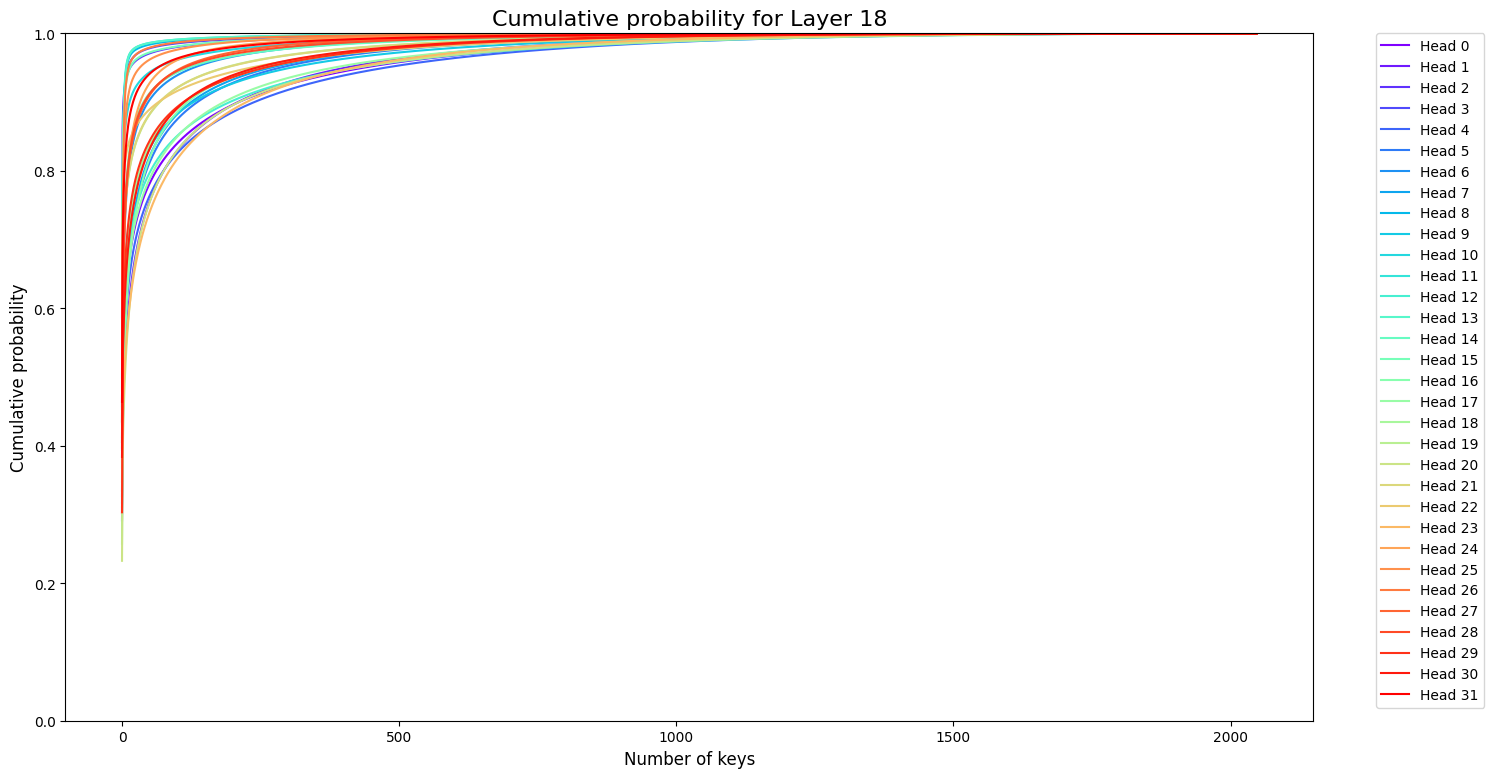

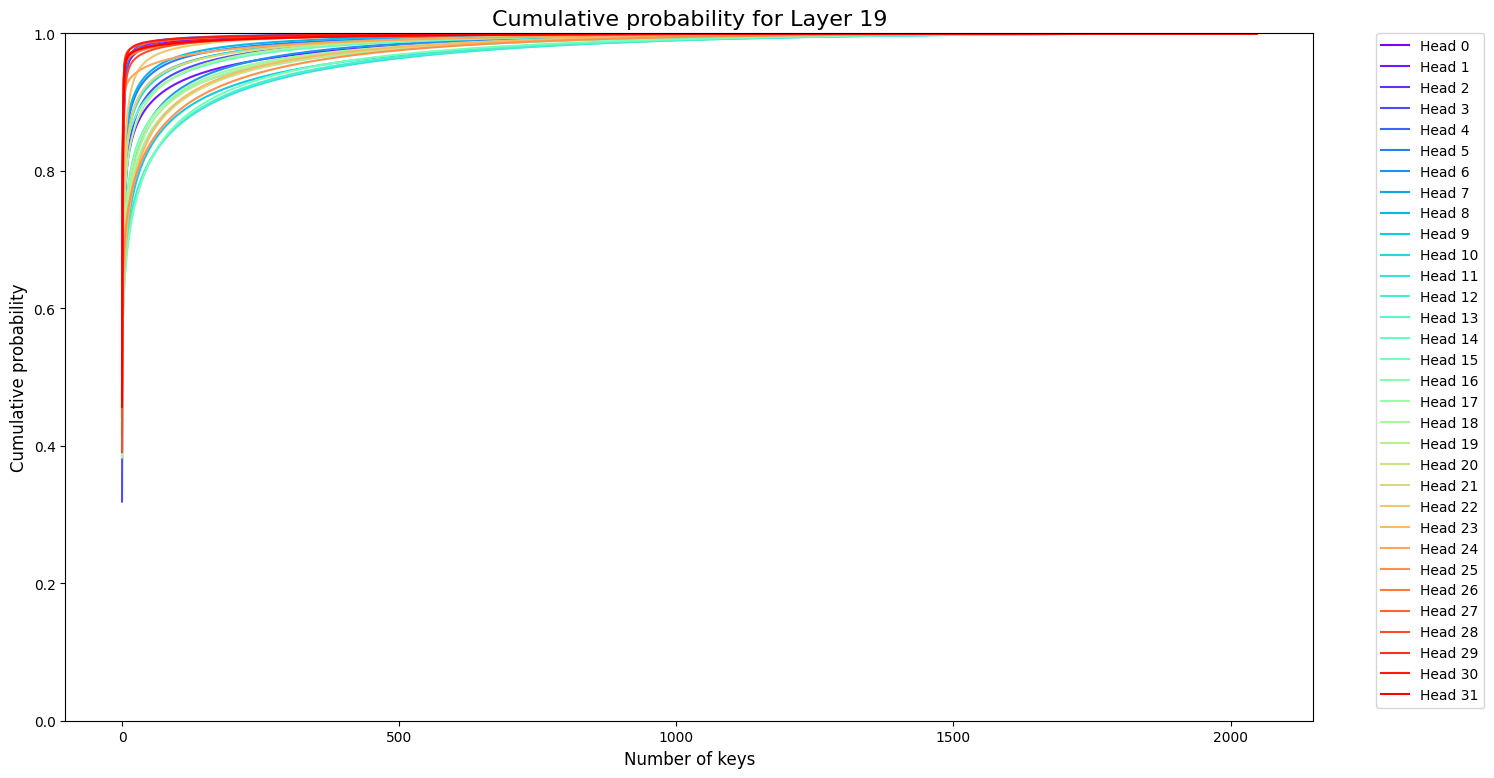

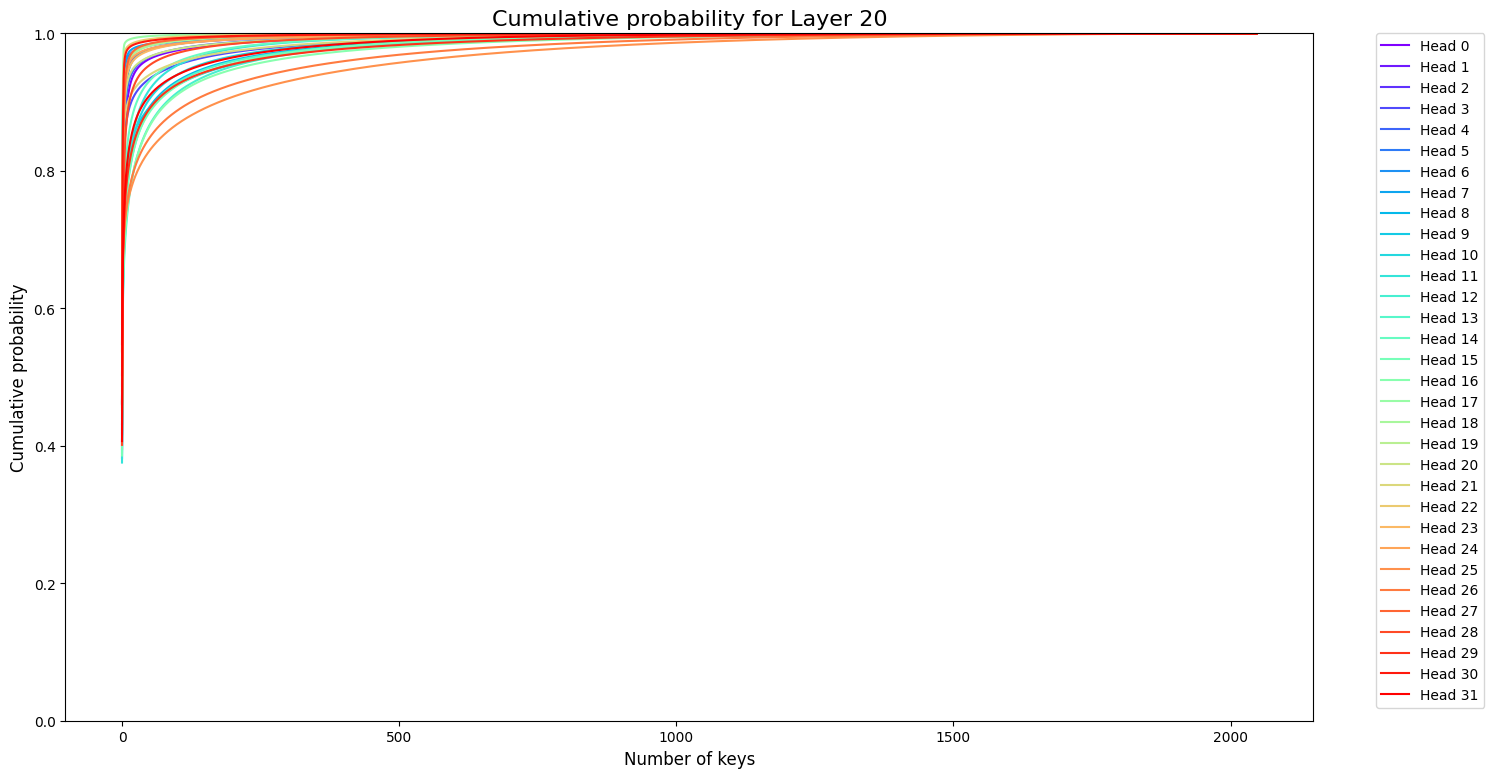

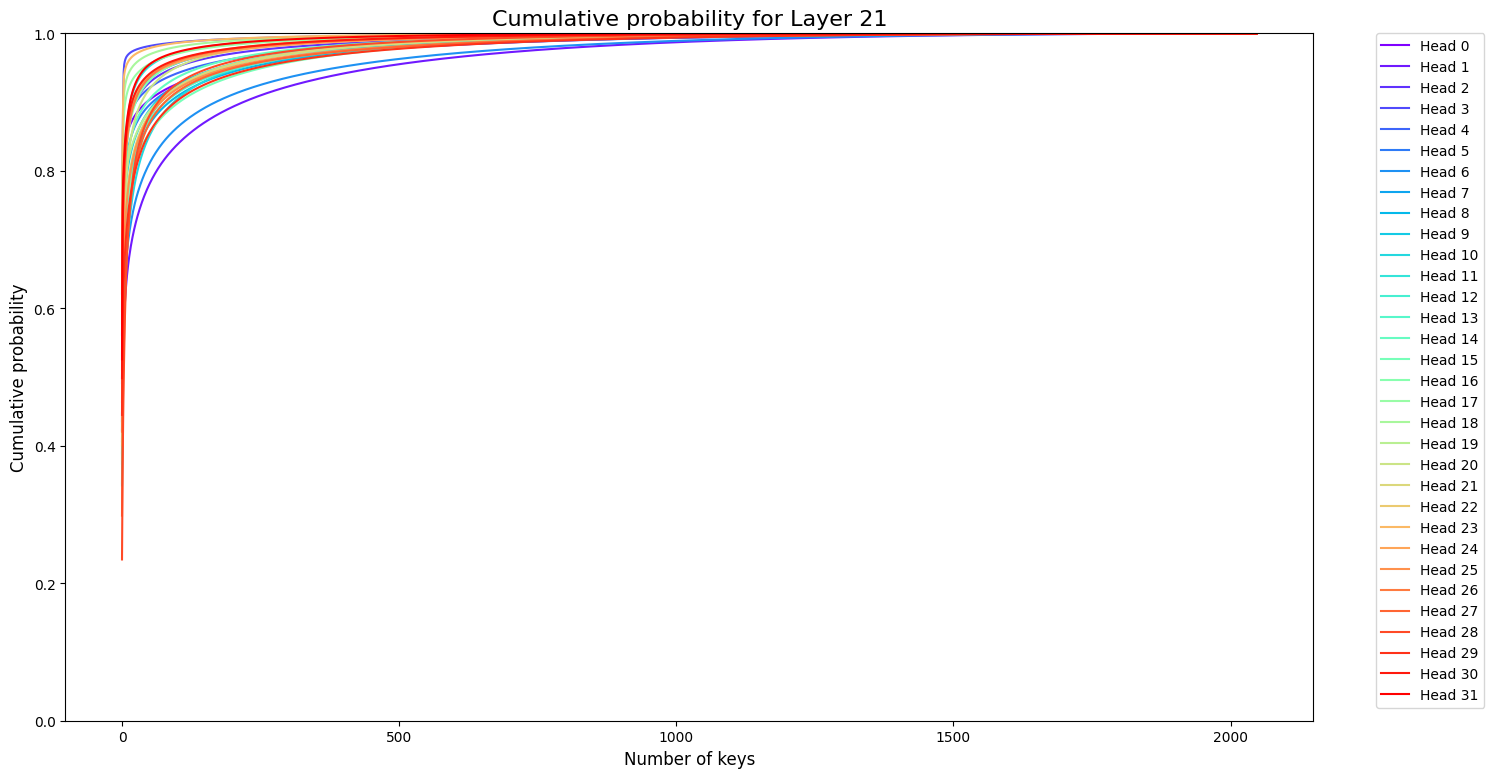

In [ ]:
# %%

plot_cum_prob_per_head(head_metrics["cum_prob"]["avg"].numpy())

In [ ]:
# %%

avg_layer_cumprob_np = layer_cumsum_metrics["avg"].numpy()
best_layer_cumprob_np = layer_cumsum_metrics["best"].numpy()
worst_layer_cumprob_np = layer_cumsum_metrics["worst"].numpy()
total_k_len = config.n_head * seq_len
probability_thresholds = [80, 90, 95, 99, 99.9]
for threshold in probability_thresholds:
    p_threshold = threshold / 100
    tokens_need_for_threshold = np.sum(avg_layer_cumprob_np <= p_threshold, axis=-1)

    print(
        f"percentage of keys needed for {threshold} % probability :\n {tokens_need_for_threshold / total_k_len * 100}"
    )

percentage of keys needed for 80 % probability :
 [5.63049316e+01 1.48483276e+01 1.43692017e+01 9.46044922e-02
 4.42504883e-02 4.73022461e-02 9.76562500e-02 1.71661377e+00
 9.30786133e-02 1.69372559e-01 1.90734863e-01 4.18090820e-01
 6.80541992e-01 7.33947754e-01 5.98144531e-01 2.99072266e-01
 5.26428223e-01 3.60107422e-01 6.24084473e-01 2.45666504e-01
 1.58691406e-01 3.58581543e-01]
percentage of keys needed for 90 % probability :
 [68.2144165  29.06646729 28.26080322  2.58026123  0.14190674  0.24871826
  0.77362061  8.203125    0.20141602  0.59814453  0.59967041  1.84326172
  2.55432129  2.61993408  2.18200684  1.33056641  2.43988037  1.85241699
  2.76947021  1.43585205  0.65917969  1.89208984]
percentage of keys needed for 95 % probability :
 [75.27008057 43.05114746 42.67730713 10.95428467  1.95617676  2.33459473
  3.52020264 18.34259033  0.73852539  2.27203369  2.02026367  5.22766113
  6.84204102  6.56280518  5.65338135  4.23431396  6.61773682  5.4901123
  7.33032227  4.86450195  

In [ ]:
# %%

def plot_cum_prob_per_head_detailed(head_metrics):
    avg_metrics, best_metrics, worst_metrics = (
        head_metrics["avg"].numpy(),
        head_metrics["best"].numpy(),
        head_metrics["worst"].numpy(),
    )
    num_layers, num_heads, seq_length = avg_metrics.shape

    # Create a color map for the heads

    for layer in range(num_layers):
        # Create a new figure for each layer

        for head in range(num_heads):

            plt.figure(figsize=(15, 8))
            # Get data for the current head
            avg_head_metrics = avg_metrics[layer, head, :]
            best_head_metrics = best_metrics[layer, head, :]
            worst_head_metrics = worst_metrics[layer, head, :]

            colors = plt.cm.rainbow(np.linspace(0, 1, 3))

            plt.plot(
                range(seq_length),
                avg_head_metrics,
                color=colors[0],
                label=f"average",
            )
            plt.plot(
                range(seq_length),
                best_head_metrics,
                color=colors[1],
                label=f"best",
            )
            plt.plot(
                range(seq_length),
                worst_head_metrics,
                color=colors[2],
                label=f"worst",
            )

            plt.title(
                f"Cumulative probability for Layer {layer} Head {head}", fontsize=16
            )
            plt.xlabel("Sequence Position", fontsize=12)
            plt.ylabel("Cumulative probability", fontsize=12)
            plt.ylim(0, 1)  # Assuming cumulative values are between 0 and 1

            # Add a legend
            plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

            plt.minorticks_on()

            plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

            plt.tight_layout()
            plt.show()

In [ ]:
# %%

if deep_dive_heads:
    plot_cum_prob_per_head_detailed(head_metrics["cum_prob"])

In [ ]:
# %%

def plot_att_wei_heatmap(att_wei_metric):
    num_layers, num_heads, seq_length = att_wei_metric.shape
    num_layers = 2
    # Create a figure with subplots for each layer
    fig, axes = plt.subplots(num_layers, 1, figsize=(15, 5 * num_layers))
    plt.subplots_adjust(top=0.95)
    fig.suptitle(
        "Confidence Probabilities Heatmap for Each Layer and Head (Log-transformed Data)",
        fontsize=16,
        y=1,
    )

    for layer in range(num_layers):
        # Get data for the current layer
        layer_data = att_wei_metric[layer]

        # Apply log transformation to the data
        # We use -np.log10(x) to invert the scale, so smaller values appear more distinct
        # Add a small constant to avoid log(0), and clip to avoid infinities
        log_data = -np.log10(np.clip(layer_data, 1e-10, 1.0))

        # Normalize log_data to [0, 1] for consistent color scaling
        log_data_norm = (log_data - log_data.min()) / (log_data.max() - log_data.min())

        # Create heatmap for the current layer
        sns.heatmap(
            log_data_norm,
            ax=axes[layer],
            cmap="viridis",
            cbar_kws={
                "label": "Confidence Probability",
                "format": lambda x, _: f"{10**(-x * (log_data.max() - log_data.min()) - log_data.min()):.2e}",
            },
            vmin=0,
            vmax=1,
        )
        axes[layer].set_title(f"Layer {layer}")
        axes[layer].set_xlabel("Sequence Position")
        axes[layer].set_ylabel("Head")

    plt.tight_layout()
    plt.show()

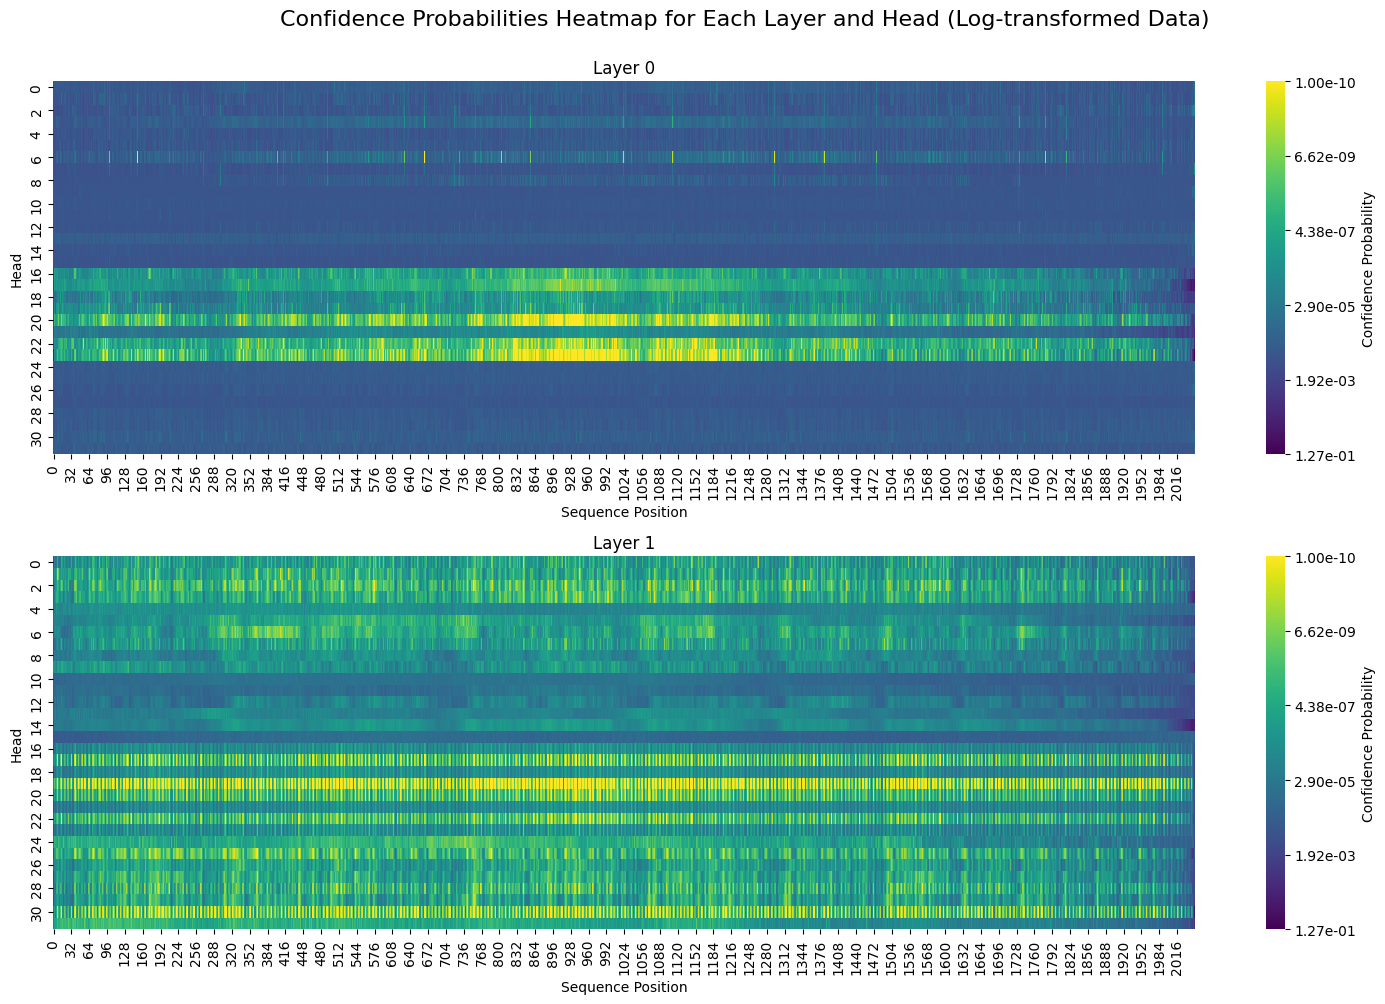

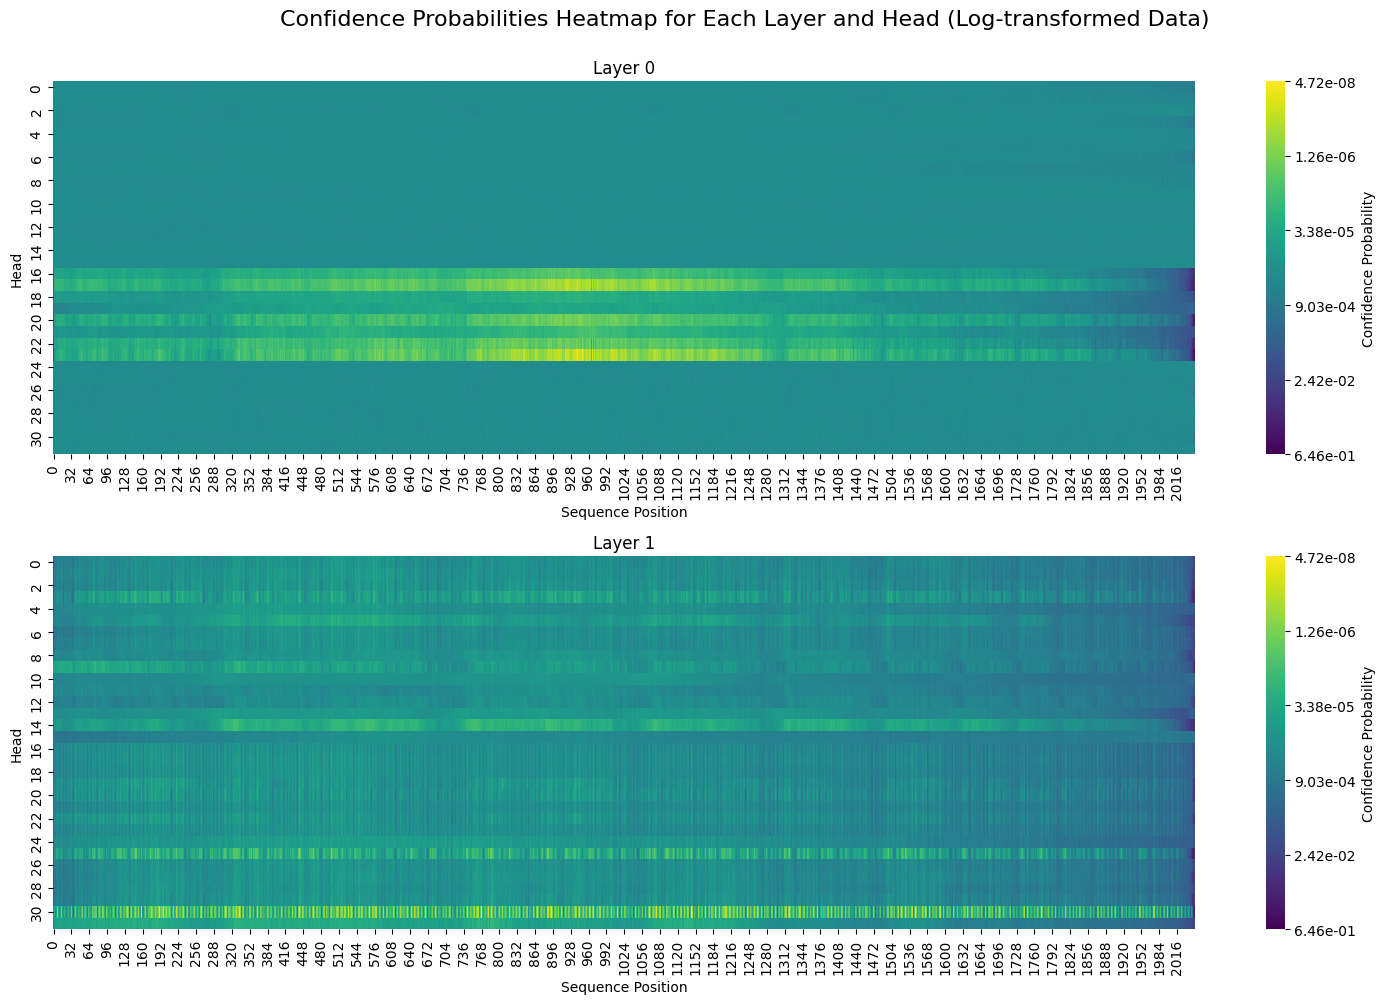

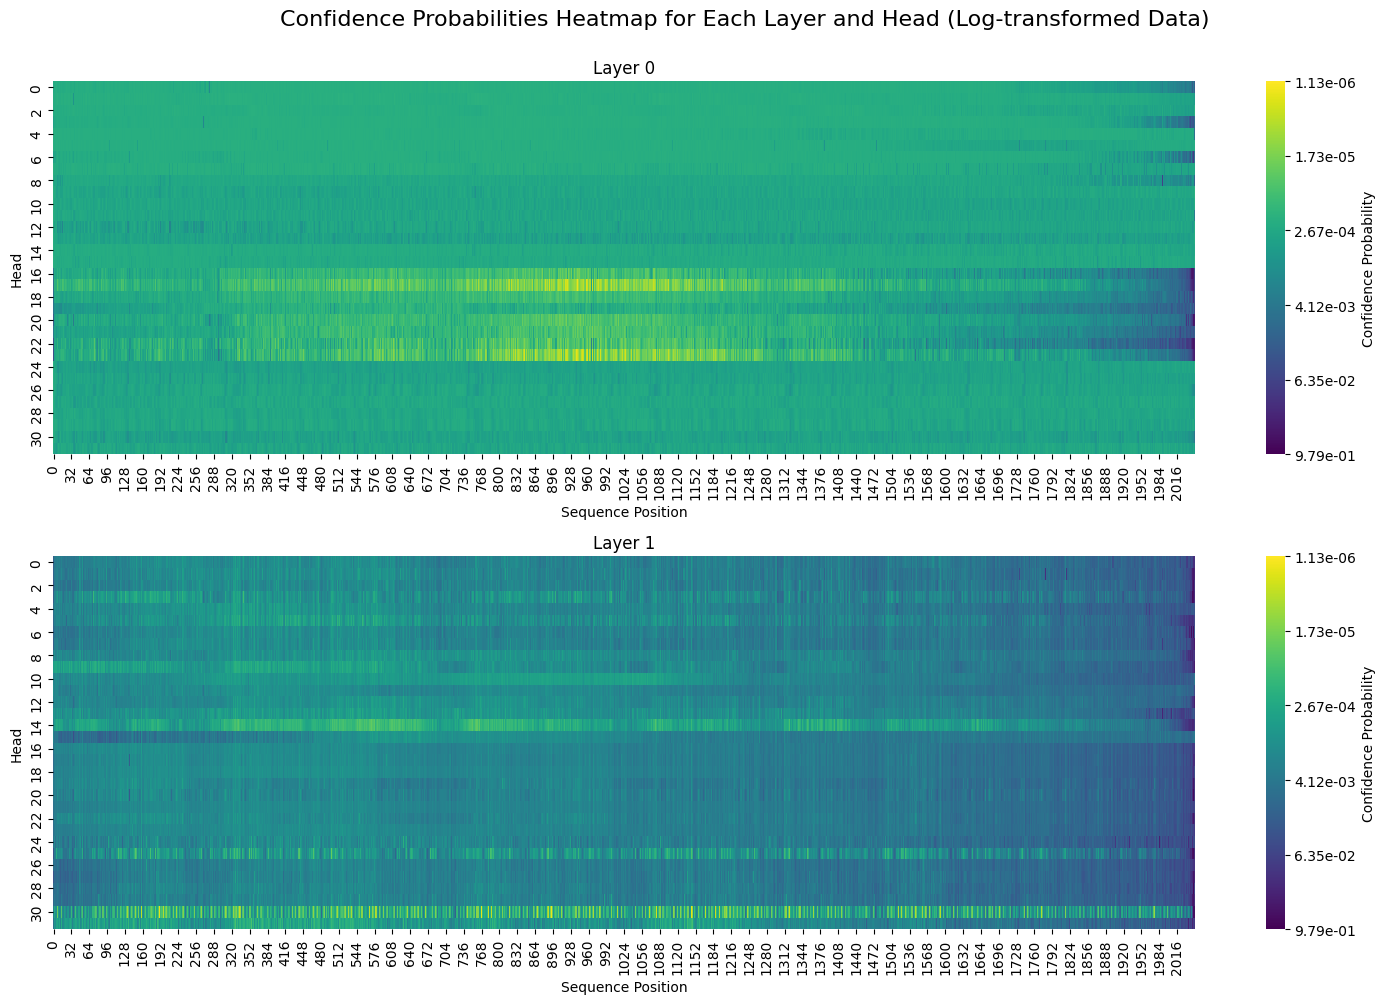

In [ ]:
# %%

plot_att_wei_heatmap(head_metrics["att_wei"]["worst"])
plot_att_wei_heatmap(head_metrics["att_wei"]["avg"])
plot_att_wei_heatmap(head_metrics["att_wei"]["best"])